In [1]:
import os
import argparse
import numpy as np
import time
import json
import gzip
import pickle
import _pickle as cPickle
import sys
sys.path.append('/home/navi3/hwing/OVG-Nav')


In [2]:
parser = argparse.ArgumentParser()



## eval configs ##
parser.add_argument("--gpu_list", type=str, default="0")
parser.add_argument("--model_gpu", type=str, default="0")
parser.add_argument("--sim_gpu", type=str, default="0")
parser.add_argument("--max_step", type=int, default=500)
parser.add_argument("--save_dir", type=str, default="/home/navi3/hwing/OVG-Nav_inference/result/realworld/0818_vo/test_edge1.0_height_0.88_lastmile5.0_actrot30")
parser.add_argument("--seed", type=int, default=1)
parser.add_argument("--vis_floorplan", type=bool, default=True)
parser.add_argument("--use_oracle", type=bool, default=False)
parser.add_argument("--goal_class", type=int, default=0)
parser.add_argument("--cm_type", type=str, default="comet")
parser.add_argument('--goal_cat', type=str, default='mp3d_21')


## observation configs ##
parser.add_argument("--front_width", type=int, default=640)
parser.add_argument("--front_height", type=int, default=480)
parser.add_argument("--front_hfov", type=float, default=55.58)

parser.add_argument("--add_panoramic_sensor", type=bool, default=True)
parser.add_argument("--panoramic_turn_angle", type=int, default=90)
parser.add_argument("--width", type=int, default=256)
parser.add_argument("--height", type=int, default=256)
parser.add_argument("--hfov", type=int, default=90)
parser.add_argument("--pano_width", type=int, default=1024)
parser.add_argument("--pano_height", type=int, default=256)
parser.add_argument("--sensor_height", type=float, default=0.88)
parser.add_argument("--goal_obs_count", type=int, default=3)

parser.add_argument("--semantic_sensor", type=bool, default=False)


## agent configs ##
parser.add_argument("--max_frames", type=int, default=500)
parser.add_argument("--sensing_range", type=float, default=5.0)
parser.add_argument("--move_forward", type=float, default=0.25)
parser.add_argument("--edge_range", type=float, default=1.0)
parser.add_argument("--last_mile_range", type=float, default=5.0)
parser.add_argument("--act_rot", type=int, default=30)
parser.add_argument("--cand_rot", type=int, default=30)
parser.add_argument("--success_dist", type=float, default=1.0)

## noise configs ##
parser.add_argument('--noisy_rgb', type=bool, default=False, help='use Gaussian noise on RGB')
parser.add_argument('--noisy_rgb_multiplier', type=float, default=0.1, help='use Gaussian noise on RGB')
parser.add_argument('--noisy_depth', type=bool, default=False, help='use RedwoodDepthNoiseModel')
parser.add_argument('--noisy_depth_multiplier', type=float, default=5., help='use RedwoodDepthNoiseModel noise multiplier')
parser.add_argument("--noise_dir", type=str, default="navigation/noise_models")
parser.add_argument('--noisy_action', type=bool, default=False, help='')
parser.add_argument('--noisy_pose', type=bool, default=False, help='')

## local navigation configs ##
parser.add_argument("--map_size_cm", type=int, default=1200)
parser.add_argument("--map_resolution", type=int, default=5)


## model configs ##
parser.add_argument("--detection_model", type=str, default="/home/navi3/hwing/OVG-Nav_inference/modules/detector")
parser.add_argument("--segmentation_model", type=str, default="/home/navi3/hwing/OVG-Nav_inference/modules/detector/rednet_mp3d.pth")
parser.add_argument("--free_space_model", type=str, default="/home/navi3/hwing/OVG-Nav_inference/modules/free_space_model/ckpts/split_lr0.001_0227_range_1.0/best_model_1.pth")
parser.add_argument("--CLIP_model", type=str, default="/home/navi3/hwing/OVG-Nav_inference/modules/comet_relation/clip-vit-base-patch32/ViT-B-32.pt")
parser.add_argument("--COMET_model", type=str, default="/home/navi3/hwing/OVG-Nav_inference/modules/comet_relation/comet-atomic_2020_BART")

# parser.add_argument("--value_model", type=str, default='/data1/hwing/Projects/offline_objgoal/goal_dist_pred/logs/cm_0610/0610_v2_1_use_cm_maxdist30.0_lr0.001/model_25.pth')
# parser.add_argument("--value_model", type=str, default='/data1/hwing/Projects/offline_objgoal/goal_dist_pred/logs/cm_0616/0616_combv2_modelv2_1_use_cm_maxdist30.0_lr0.0001/model_20.pth')
parser.add_argument("--value_model", type=str, default='/home/navi3/hwing/OVG-Nav_inference/goal_dist_pred/models/16-56_mp3d21_edge1v1.12_panov8_layer10_hidden512_epoch_6_goalscore_w_adjmtx_valueloss1.0_adjloss100.0_adjsimlos0.0_signloss0.0_use_cm_maxdist30.0_lr0.001/model.pth')
parser.add_argument('--vis_feat_dim', default=512, type=int)
parser.add_argument('--gcn_layers', default=10, type=int)
parser.add_argument('--use_cm_score', default=True, type=bool)


## VO model configs ##
parser.add_argument("--use_vo", type=bool, default=True)
parser.add_argument('--max_depth', type=float, default=5., help='maximum depth value')
parser.add_argument('--min_depth', type=float, default=0.1, help='minimum depth value')
parser.add_argument('--KM_resize', type=int, nargs='+', default=[640, 480],
        help='Resize the input image before running inference. If two numbers, '
             'resize to the exact dimensions, if one number, resize the max '
             'dimension, if -1, do not resize')
parser.add_argument('--KM_superglue', choices={'indoor', 'outdoor'}, default='indoor', help='SuperGlue weights')
parser.add_argument('--KM_max_keypoints', type=int, default=1024, help='Maximum number of keypoints detected by Superpoint' ' (\'-1\' keeps all keypoints)')
parser.add_argument('--KM_keypoint_threshold', type=float, default=0.005, help='SuperPoint keypoint detector confidence threshold')
parser.add_argument('--KM_nms_radius', type=int, default=4, help='SuperPoint Non Maximum Suppression (NMS) radius' ' (Must be positive)')
parser.add_argument('--KM_sinkhorn_iterations', type=int, default=20, help='Number of Sinkhorn iterations performed by SuperGlue')
parser.add_argument('--KM_match_threshold', type=float, default=0.2, help='SuperGlue match threshold')


args = parser.parse_args(args=[])
os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu_list
os.environ["OMP_NUM_THREADS"] = "1"

In [3]:
import math
import random
from enum import Enum
if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2
import torch
torch.set_num_threads(1)

import numpy as np
from PIL import Image

import quaternion
from scipy.spatial.transform import Rotation as R
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path
import skimage

_barrier = None

import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('TkAgg')
%matplotlib inline

from utils.graph_utils.graph_pano_cs import GraphMap
from utils.obj_category_info import assign_room_category, obj_names_det as obj_names, gibson_goal_obj_names, mp3d_goal_obj_names, room_names, mp3d_room_names, d3_40_colors_rgb, rednet_obj_names


from modules.detector.detector_mask import Detector
from modules.detector.rednet_semantic_prediction import SemanticPredRedNet
from modules.free_space_model.inference import FreeSpaceModel
from modules.comet_relation.inference import CommonSenseModel
from modules.visual_odometry.keypoint_matching import KeypointMatching
from modules.value_estimation.model_value_graph_0607 import TopoGCN_v8_pano_goalscore as ValueModel


from navigation.validity_func.map_builder import build_mapper
from navigation.validity_func.fmm_planner import FMMPlanner
from validity_func.local_nav import LocalAgent
from validity_func.validity_utils import (
    get_relative_location,
    get_sim_location,
)

In [4]:
from navigation.navi_controller import Controller
controller = Controller()
controller.act_rot = args.act_rot

python 3.7.10 (default, Feb 26 2021, 18:47:35) 
[GCC 7.3.0]


In [5]:
# import pyrealsense2 as rs
# frames = controller.pipeline.wait_for_frames()
# align = rs.align(rs.stream.color)
# aligned_frames = align.process(frames)

# depth_frame = aligned_frames.get_depth_frame()
# color_frame = aligned_frames.get_color_frame() 

# depth_frame = controller.decimation.process(depth_frame)
# depth_frame = controller.depth_to_disparity.process(depth_frame)
# depth_frame = controller.spatial.process(depth_frame)
# depth_frame = controller.disparity_to_depth.process(depth_frame)
# # depth_frame = controller.hole_filling.process(depth_frame)

# color_array=np.array(color_frame.get_data())#set_color(np.array(color_frame.get_data()))
# depth_array=np.array(depth_frame.get_data())

# plt.subplot(121)
# plt.imshow(color_array)
# plt.subplot(122)
# plt.imshow(depth_array)
# plt.show()

In [6]:
det_COI = [
        56,  # chair
        57,  # couch
        58,  # potted plant
        59,  # bed
        61,  # toilet
        62,  # tv
        60,  # dining table
        63,  # laptop
        68,  # microwave
        69,  # oven
        71,  # sink
        72,  # refrigerator
        74,  # clock
        75,  # vase
    ]


## RUNNER

In [7]:
class Runner:
    def __init__(self, args, COI, data_type='infer'):
        self.args = args
        self._sim_settings = sim_settings.copy()
        self.dataset = dataset
        self.dataset_info = None
        self.gt_planner = None
        self.data_type = data_type

        self.det_COI = COI
        self.obj_names = obj_names
        if args.dataset == 'mp3d':
            self.goal_obj_names = mp3d_goal_obj_names
        elif args.dataset == 'gibson':
            self.goal_obj_names = gibson_goal_obj_names
        # self.sge_th = args.sge_th
        if self.args.goal_cat == 'mp3d_21':
            self.goal_obj_names = rednet_obj_names

        self.pix_num = args.width*args.height
        self.cand_angle = np.arange(-120, 240, args.cand_rot)
        self.cand_angle_bias = list(self.cand_angle).index(0) # 0 degree is the center
        self.edge_range = args.edge_range
        self.last_mile_range = args.last_mile_range
        self.goal_det_dist = args.success_dist - args.move_forward
        self.goal_obs_consistency_th = args.goal_obs_count # number of time steps that the goal is visible for the goal to be considered as correctly detected

        self.vo_height = args.front_height
        self.vo_width = args.front_width
        self.vo_hfov = args.front_hfov

        self.height = args.height
        self.width = args.width

        self.pano_width = args.pano_width
        self.pano_height = args.pano_height

        self.hfov = args.hfov
        self.camera_height = args.sensor_height

        self.step_size = args.move_forward
        self.follower_goal_radius = 0.75 * self.step_size
        self.act_rot = args.act_rot
        self.cand_rot_angle = args.cand_rot
        self.rot_num = len(self.cand_angle)
        self.max_local_action_trial = 50
        self.max_step = args.max_step

        # self.vo_pred_model = VO_prediction(args.vo_config)
        self.depth_scale = np.iinfo(np.uint16).max

        self.goal_cat = args.goal_cat
        if args.goal_cat == 'mp3d':
            self.detector = Detector(args, self.det_COI)
        elif args.goal_cat == 'mp3d_21':
            self.detector = SemanticPredRedNet(args)
        self.free_space_model = FreeSpaceModel(args)
        self.common_sense_model = CommonSenseModel(args)
        # self.noisy_pose = args.noisy_pose
        self.vo_model = KeypointMatching(args)

        self.value_model = ValueModel(self.args)
        # self.value_model = nn.DataParallel(self.value_model).cuda()
        # self.value_model.load_state_dict(torch.load(self.args.value_model))
        state_dict = torch.load(self.args.value_model)
        new_state_dict = {}
        for k, v in state_dict.items():
            if 'module' in k:
                k = k.replace('module.', '')
            new_state_dict[k] = v
        self.value_model.load_state_dict(new_state_dict)
        self.value_model = self.value_model.to(f'cuda:{args.model_gpu}')
        self.value_model.eval()

        # self.local_navi_module = LocalNavigation(self.args, self.vo_model)
        self.local_agent = LocalAgent(self.args)
        self.local_mapper = build_mapper(self.args)



        self.vis_floorplan = args.vis_floorplan
        self.use_oracle = args.use_oracle
        self.cm_type = args.cm_type  ### 'comet or mp3d'

        self.cand_node_frame = get_range_cand_nodes(int(args.sensing_range / self.edge_range), self.edge_range)

        ## -- localization template -- ##

        self.rot_grid = {'move_forward': [], 'turn_left': [], 'turn_right': []}
        rot_angle = 5 * np.pi / 180.
        self.localize_rot_num = 7
        self.rot_grid_headings = {'move_forward': [], 'turn_left': [], 'turn_right': []}
        for i in range(-3, 4):
            angle_0 = rot_angle * i
            self.rot_grid['move_forward'].append(torch.FloatTensor(
                [[np.cos(angle_0), -np.sin(angle_0), 0],
                 [np.sin(angle_0), np.cos(angle_0), 0]]))
            self.rot_grid_headings['move_forward'].append(-angle_0)

            angle_1 = rot_angle * i - self.act_rot * np.pi / 180
            self.rot_grid['turn_left'].append(torch.FloatTensor(
                [[np.cos(angle_1), -np.sin(angle_1), 0],
                 [np.sin(angle_1), np.cos(angle_1), 0]]))
            self.rot_grid_headings['turn_left'].append(-angle_1)

            angle_2 = rot_angle * i + self.act_rot * np.pi / 180
            self.rot_grid['turn_right'].append(torch.FloatTensor(
                [[np.cos(angle_2), -np.sin(angle_2), 0],
                 [np.sin(angle_2), np.cos(angle_2), 0]]))
            self.rot_grid_headings['turn_right'].append(-angle_2)
        local_map_size = self.local_mapper.gt_map.shape[0]
        self.local_map_size = local_map_size
        self.rot_grid['move_forward'] = torch.stack(self.rot_grid['move_forward'])
        self.rot_grid['move_forward'] = F.affine_grid(self.rot_grid['move_forward'], torch.Size((self.localize_rot_num, 1, local_map_size, local_map_size)))
        self.rot_grid['turn_left'] = torch.stack(self.rot_grid['turn_left'])
        self.rot_grid['turn_left'] = F.affine_grid(self.rot_grid['turn_left'], torch.Size((self.localize_rot_num, 1, local_map_size, local_map_size)))
        self.rot_grid['turn_right'] = torch.stack(self.rot_grid['turn_right'])
        self.rot_grid['turn_right'] = F.affine_grid(self.rot_grid['turn_right'], torch.Size((self.localize_rot_num, 1, local_map_size, local_map_size)))




    def save_rgbd_video(self, rgb_list, depth_list, save_dir, panoramic=False):
        if panoramic:
            width = self.pano_width
            height = self.pano_height
            rgb_name = 'pano_rgb'
            depth_name = 'pano_depth'
        else:
            width = self.vo_width
            height = self.vo_height
            rgb_name = 'rgb'
            depth_name = 'depth'

        video = cv2.VideoWriter(f'{save_dir}/{rgb_name}.avi', cv2.VideoWriter_fourcc(*'XVID'), 5,
                                (width, height))
        for image in rgb_list:
            image = cv2.cvtColor((image[:, :, :3] / 255.).astype(np.float32), cv2.COLOR_RGB2BGR)
            video.write((image * 255).astype(np.uint8))
        video.release()

        video = cv2.VideoWriter(f'{save_dir}/{depth_name}.avi', cv2.VideoWriter_fourcc(*'XVID'), 5,
                                (width, height), isColor=False)
        for depth_obs in depth_list:
            depth_obs = (np.clip(depth_obs, 0.1, 10.) / 10.).astype(np.float32)
            depth_obs = (depth_obs * self.depth_scale).astype(np.uint16) / self.depth_scale
            depth_obs = (depth_obs * 255).astype(np.uint8)
            video.write(depth_obs)
        video.release()

    def save_video(self, frame_list, save_dir):
        if not os.path.exists(save_dir): os.makedirs(save_dir)

        width = np.shape(frame_list[0])[1]
        height = np.shape(frame_list[0])[0]

        video = cv2.VideoWriter(f'{save_dir}/graph.avi', cv2.VideoWriter_fourcc(*'XVID'), 5,
                                (width, height))
        for image in frame_list:
            image = cv2.cvtColor((image[:, :, :3] / 255.).astype(np.float32), cv2.COLOR_RGB2BGR)
            video.write((image * 255).astype(np.uint8))
        video.release()

    def make_total_frame(self, rgb, depth, graph, local_map, pano_rgb, info, frame_num=None):
        rh, rw = np.shape(rgb)[:2]
        rh, rw = int(rh / 2), int(rw / 2)
        small_rgb = cv2.resize(rgb, (rw, rh))
        small_depth = cv2.resize(depth, (rw, rh))
        small_depth = ((np.clip(small_depth, 0.1, 10.) / 10.) * 255).astype(np.uint8)
        gh, gw = np.shape(graph)[:2]
        gh, gw = int(rw * 2 * gh / gw), rw * 2
        ph, pw = np.shape(pano_rgb)[:2]
        ph, pw = int(rw / 2), rw * 2
        small_pano_rgb = cv2.resize(pano_rgb.astype(np.uint8), (pw, ph))

        lh, lw = np.shape(local_map)[:2]
        local_map = cv2.flip(local_map, 1)
        # lh, lw = int(lh/2), int(lw/2)
        # local_map = cv2.resize(local_map, (lw, lh))

        small_graph = cv2.resize(graph, (gw, gh))
        max_h = rh + ph + gh + lh
        max_w = max(rw*2, gw, lw, pw)

        frame = np.zeros([max_h, max_w, 3])
        frame[:rh, :rw, :] = small_rgb[:, :, :3]
        frame[:rh, rw:rw*2, :] = np.tile(small_depth[:, :, np.newaxis], [1, 1, 3])
        frame[rh:rh+ph, :pw, :] = small_pano_rgb[:, :, :3]
        frame[rh+ph:rh+ph+gh, :gw, ] = small_graph
        frame[rh+ph+gh:, :lw, :] = local_map[:, :, :3]
        frame = frame.astype(np.uint8)


        ## text
        text1 = "Target object goal: {}   Mode: {}".format(info['target_goal'], info['mode'])
        text2 = "Step: {}   Position: {}".format(info['step'], info['cur_position'])
        font_color = (255, 255, 255)
        text_size, _ = cv2.getTextSize(text1, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
        # text_position1 = (int((frame.shape[1] - text_size[0]) / 2), frame.shape[0] + text_size[1] * 2 + 10)
        # text_position2 = (int((frame.shape[1] - text_size[0]) / 2), frame.shape[0] + text_size[1] * 2 + 25)
        text_position1 = (10, frame.shape[0] + text_size[1] * 2 + 10)
        text_position2 = (10, frame.shape[0] + text_size[1] * 2 + 25)
        canvas_height = frame.shape[0] + text_size[1] * 2 + 40
        canvas_width = frame.shape[1]
        canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)
        canvas[:frame.shape[0], :] = frame
        # canvas = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
        frame2 = cv2.putText(canvas, text1, text_position1, cv2.FONT_HERSHEY_SIMPLEX, 0.4, font_color, 1, cv2.LINE_AA)
        frame2 = cv2.putText(canvas, text2, text_position2, cv2.FONT_HERSHEY_SIMPLEX, 0.4, font_color, 1, cv2.LINE_AA)
        
        if not frame_num is None:
            if not os.path.exists('epi_{0:02d}'.format(self.epi_num)):
                os.makedirs('epi_{0:02d}'.format(self.epi_num))
            plt.imsave('epi_{0:02d}/frame_{1:04d}.png'.format(self.epi_num, frame_num), frame2)
        return frame2



    def panoramic_obs(self, obs, semantic=False):

        rgb_panoramic = np.zeros([self.pano_height, self.pano_width, 3]).astype(int)
        # depth_panoramic = np.zeros([self.pano_height, self.pano_width])
        if semantic:
            semantic_panoramic = np.zeros([self.pano_height, self.pano_width]).astype(int)

        for i, rot in enumerate([ '270', '0', '90', '180']):

            rgb_panoramic[:, i * self.width:(i + 1) * self.width, :] = obs[f'rgb_{rot}'][:, :, :3]   # 320 - 320* np.tan(30/180*np.pi) / np.tan(35/180*np.pi) = 56
            # depth_panoramic[:, i * self.width:(i + 1) * self.width] = obs[f'depth_{rot}']

        return {
            'rgb_panoramic': rgb_panoramic,
            # 'depth_panoramic': depth_panoramic
        }

    def init_commonsense_candidate_room(self, goal_names, candidate_names):
        goal_category_room = {}
        goal_category_room_feat = {}
        goal_category_room_score = {}

        cand_category_room = {}
        cand_category_room_feat = {}
        cand_category_room_score = {}
        cand_room_feat = self.common_sense_model.clip.get_text_feat(candidate_names).type(torch.float32)
        for i, goal_name in enumerate(goal_names):
            pred_words = self.common_sense_model.gen_pred_words(self.goal_obj_names[i] + ' in an indoor space',
                                                                num_generate=10)
            # pred_words = pred_words[0]
            pred_words_feat = self.common_sense_model.clip.get_text_feat(pred_words).type(torch.float32)

            goal_category_room[goal_name] = pred_words
            goal_category_room_feat[goal_name] = pred_words_feat.cpu()
            goal_category_room_score[goal_name] = np.ones_like(pred_words).astype(float)

            value, indice = torch.max(
                self.common_sense_model.clip.get_sim_from_feats(cand_room_feat, pred_words_feat, normalize=True).type(
                    torch.float32),
                dim=0)
            topk = torch.topk(value, k=len(candidate_names), largest=True).indices.detach().cpu().numpy()
            cand_category_room[goal_name] = [candidate_names[i] for i in topk]
            cand_category_room_feat[goal_name] = torch.stack([cand_room_feat[i].detach().cpu() for i in topk])
            cand_category_room_score[goal_name] = np.array([value[i].detach().cpu().numpy() for i in topk])

        return goal_category_room, goal_category_room_feat, goal_category_room_score, cand_category_room, cand_category_room_feat, cand_category_room_score


    def node_value_by_obj_dist(self, dist, max_dist=15.0):
        return max(1 - dist / max_dist, 0)
    
    def get_vis_grid_pose(self, pose):
        grid_size = (0.02, 0.02)
        lower_bound_x = -10
        lower_bound_y = -10
        if len(pose) == 3:
            pose = np.array(pose)
            grid_x = int((pose[0] - lower_bound_y) / grid_size[1])
            grid_y = int((pose[2] - lower_bound_x) / grid_size[0])
            
        elif len(pose) == 2:
            grid_x = int((pose[0] - lower_bound_y) / grid_size[1])
            grid_y = int((pose[1] - lower_bound_x) / grid_size[0])
            
        return (grid_x, grid_y)

    def vis_topdown_graph_map(self, vis_map, graph_map, vis_obj_score=None, curr_node_id=None, curr_goal_node_id=None,
                              bias_position=None, curr_goal_position=None, visited_positions=None):
        node_list = list(graph_map.node_by_id.values())

        for edge in list(graph_map.edges):
            if not edge.draw:
                pos1 = np.array(edge.nodes[0].pos) if edge.nodes[0].vis_pos is None else np.array(edge.nodes[0].vis_pos)
                pos2 = np.array(edge.nodes[1].pos) if edge.nodes[1].vis_pos is None else np.array(edge.nodes[1].vis_pos)
                node_grid1 = self.get_vis_grid_pose(pos1 + bias_position)
                node_grid2 = self.get_vis_grid_pose(pos2 + bias_position)
                vis_map = cv2.line(vis_map, node_grid1, node_grid2, (0, 64, 64), 5)
                edge.draw = True

        cm_scores = []
        for node in node_list:
            cm_scores.append(node.cm_score)
        cm_scores = np.array(cm_scores)
        cm_scores = np.exp(cm_scores) / np.sum(np.exp(cm_scores))

        for idx, node in enumerate(node_list):

            node_pos = np.array(node.pos) if node.vis_pos is None else np.array(node.vis_pos)

            node_grid = self.get_vis_grid_pose(node_pos + bias_position)
            if vis_obj_score is not None:
                color = (0, 255, 0)
                cand_color = (np.array((0, 0, 255)) * cm_scores[idx]).astype(int)
                cand_color = tuple([cand_color[i].item() for i in range(3)])
                goal_color = (255, 255, 0)
            else:
                color = (0, 255, 0)
                cand_color = (0, 0, 255)
                goal_color = (255, 255, 0)
            if node.visited:
                if node.nodeid == curr_node_id:
                    vis_map = cv2.circle(vis_map, node_grid, 10, (255,0,0), -1)
                else:
                    vis_map = cv2.circle(vis_map, node_grid, 10, color, -1)
            elif node.nodeid == curr_goal_node_id:
                vis_map = cv2.circle(vis_map, node_grid, 10, goal_color, -1)
            else:
                vis_map = cv2.circle(vis_map, node_grid, 10, cand_color, -1)

            node.draw = True

        if visited_positions is not None:
            for pos in visited_positions:
                node_grid = self.get_vis_grid_pose(pos + bias_position)
                vis_map = cv2.circle(vis_map, node_grid, 5, (125, 0, 0), -1)

        if curr_goal_position is not None:
            node_grid = self.get_vis_grid_pose(curr_goal_position + bias_position)
            vis_map = cv2.rectangle(vis_map, (node_grid[0] - 8, node_grid[1] - 8), (node_grid[0] + 8, node_grid[1] + 8),
                                    (255, 255, 0), -1)

        return vis_map

    def vis_pos_on_topdown_map(self, pos, vis_map, color=(255, 0, 0)):
        vis_map = vis_map.copy()
        node_grid = self.get_vis_grid_pose(pos)
        vis_map = cv2.rectangle(vis_map, (node_grid[0] - 8, node_grid[1] - 8), (node_grid[0] + 8, node_grid[1] + 8),
                                color, -1)
        return vis_map

    def save_viewpoint_on_topdown_map(self, save_dir=None, vis_map=None, bias_position=None, curr_position=None, curr_goal_position=None, result=None):

        mask = np.repeat(np.sum(self.cur_graph_map, axis=2).astype(bool)[:,:,np.newaxis], 3, axis=2)
        vis_map[mask] = cv2.addWeighted(vis_map, 0.0, self.cur_graph_map, 1.0, 0)[mask]

        if curr_position is not None:
            node_grid = self.get_vis_grid_pose(curr_position + bias_position)
            vis_map = cv2.rectangle(vis_map, (node_grid[0] - 8, node_grid[1] - 8), (node_grid[0] + 8, node_grid[1] + 8),
                                    (255, 0, 0), -1)
        if curr_goal_position is not None:
            node_grid = self.get_vis_grid_pose(curr_goal_position + bias_position)
            vis_map = cv2.rectangle(vis_map, (node_grid[0] - 8, node_grid[1] - 8), (node_grid[0] + 8, node_grid[1] + 8),
                                    (255, 255, 0), -1)

        if result is not None:
            success = 'SUCCESS' if result['success'] == 1 else 'FAIL'
            txt = 'goal: {}, success: {}, path length: {:.4f}, actions {}'.format(result['goal object'], success,
                                                                                  result['path_length'],
                                                                                  result['action step'])
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 1
            color = (255, 255, 255)
            thickness = 2
            text_size = cv2.getTextSize(txt, font, font_scale, thickness)[0]
            text_position = (10, vis_map.shape[0] + text_size[1] * 2 + 10)
            canvas_height = vis_map.shape[0] + text_size[1] * 2 + 40
            canvas_width = vis_map.shape[1]
            canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)
            canvas[:vis_map.shape[0], :] = vis_map
            canvas = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
            cv2.putText(canvas, txt, text_position, font, font_scale, color, thickness)
            cv2.imwrite(save_dir, canvas)
        else:
            plt.imsave(save_dir, vis_map)

        return



    def vis_topdown_map_with_captions(self, graph_map, curr_node=None, curr_goal_node=None,
                                      bias_position=None, curr_position=None, curr_goal_position=None,
                                      vis_goal_obj_score=None, vis_obj=None,
                                      visited_positions=None):
        vis_map = self.cur_graph_map

        curr_node_id, curr_goal_node_id = None, None
        if curr_node is not None:
            curr_node_id = curr_node.nodeid
        if curr_goal_node is not None:
            curr_goal_node_id = curr_goal_node.nodeid
        vis_map = self.vis_topdown_graph_map(vis_map, graph_map, vis_obj_score=vis_goal_obj_score,
                                                curr_node_id=curr_node_id, curr_goal_node_id=curr_goal_node_id,
                                                bias_position=bias_position,
                                                visited_positions=visited_positions)

        self.cur_graph_map = vis_map
        mask = np.repeat(np.sum(self.cur_graph_map, axis=2).astype(bool)[:,:,np.newaxis], 3, axis=2)
        self.base_map[mask] = cv2.addWeighted(self.base_map, 0., self.cur_graph_map, 1.0, 0)[mask]

        if curr_position is not None:
            vis_map = self.vis_pos_on_topdown_map(curr_position + bias_position, self.base_map)
        if curr_goal_position is not None:
            vis_map = self.vis_pos_on_topdown_map(curr_goal_position + bias_position, vis_map, color=(255, 255, 0))



        return vis_map

    def dist_euclidean_floor(self, pos1, pos2):
        return np.sqrt((pos1[0] - pos2[0]) ** 2 + (pos1[2] - pos2[2]) ** 2)
    
    def get_vo_relative_camera_pose(self, prev_rgb, prev_depth, curr_rgb, action, cur_rotation, prev_local_map, curr_local_map, initial_guess=None):
        # if initial_guess is None:
        #     initial_guess = self.vo_model.get_extrinsic_guess_from_action(action)


        curr_map = torch.Tensor(curr_local_map).unsqueeze(0).unsqueeze(0)
        if action == 'move_forward':
            unit_vec = -np.array([np.sin(cur_rotation[1]), 0, np.cos(cur_rotation[1])])
            cand_pos = self.cur_position + unit_vec * self.step_size
            cand_pose_for_map = (cand_pos[0], cand_pos[2], cur_rotation[1])
            cand_pose_on_grid_map_cm = self.local_mapper.get_mapper_pose_from_sim_pose(cand_pose_for_map, (
                                        self.cur_position[0], self.cur_position[2], 0))
            cand_pose_on_grid_map = self.local_mapper.get_map_grid_from_sim_pose_cm(cand_pose_on_grid_map_cm)
            prev_map = self.crop_and_pad(torch.Tensor(prev_local_map), cand_pose_on_grid_map[0], cand_pose_on_grid_map[1])
            prev_map = prev_map.unsqueeze(0).unsqueeze(0)
        else:
            prev_map = torch.Tensor(prev_local_map).unsqueeze(0).unsqueeze(0)


        rot_filter = F.grid_sample(curr_map.repeat(self.localize_rot_num, 1, 1, 1), self.rot_grid[action])
        localize = F.conv2d(prev_map, rot_filter, padding=3)
        cand_map_idx = np.unravel_index(np.argmax(localize), localize.shape)

        if torch.max(localize) == 0:
            initial_guess = self.vo_model.get_extrinsic_guess_from_action(action)
        else:
            rot_guess = np.array([0, self.rot_grid_headings[action][cand_map_idx[1]], 0]).astype(np.float32)

            if action == 'move_forward':
                cand_map_pos_idx = (cand_pose_on_grid_map[1] + cand_map_idx[3] - 4, cand_pose_on_grid_map[0] + cand_map_idx[2] - 4)
            else:
                cand_map_pos_idx = (int(self.local_map_size/2) + cand_map_idx[3] - 4, int(self.local_map_size/2) + cand_map_idx[2] - 4)
            pos_guess = self.local_mapper.get_sim_pose_from_mapper_coords(cand_map_pos_idx, (0,0,0), rot_guess)

            initial_guess = {
                'tvec': pos_guess,
                'rvec': rot_guess
            }

        torch.set_num_threads(1)
        est_pos_diff, est_rot_diff, keypoint_est_success = self.vo_model.get_relative_camera_pose(
                                                            prev_rgb, prev_depth, curr_rgb, initial_guess, rot_vec=True)

        # ## -- transform to habitat coordinate -- ##
        # est_pos_diff[2] = -est_pos_diff[2]
        # est_pos_diff[1] = -est_pos_diff[1]

        rot = R.from_rotvec(cur_rotation)
        rot.as_matrix()
        est_pos_diff = rot.apply(est_pos_diff)


        return est_pos_diff, est_rot_diff, keypoint_est_success


    def get_dirc_imgs_from_pano(self, pano_img, num_imgs=12):
        pw, ph = self.pano_width, self.pano_height

        width_bias = int(1 / (self.rot_num * 2) * pw)
        width_half = int(ph / 2)

        # split the panorama into 12 square images with even angles
        dirc_imgs = []
        for i in range(num_imgs):
            angle = i * 360 / num_imgs
            x = int(pw * (angle / 360)) + width_bias
            start_w = x - width_half
            end_w = x + width_half

            if start_w < 0:
                dirc_img = np.concatenate((pano_img[:, start_w:], pano_img[:, :end_w]), axis=1)
            elif end_w > self.pano_width:
                dirc_img = np.concatenate((pano_img[:, start_w:], pano_img[:, :end_w - self.pano_width]), axis=1)
            else:
                dirc_img = pano_img[:, start_w:end_w]

            # dirc_img = pano_img[:, x:x + ph]
            # if x + ph > pw:
            #     dirc_img = np.concatenate((dirc_img, pano_img[:, :x + ph - pw]), axis=1)
            dirc_imgs.append(dirc_img)
        return np.array(dirc_imgs)


    def get_cand_node_dirc(self, pano_rgb, depth, pos, rot, vis_pos=None):
        ## rot is rotation vector
        cur_heading_idx = int(np.round(-rot[1] * 180 / np.pi / self.cand_rot_angle)) % self.rot_num
        cand_nodes = []
        cand_angle = [-30, 0, 30]
        self.local_mapper.reset_map()
        depth_cm = depth * 100
        pose_origin_for_map = (pos[0], pos[2], 0)  # (x, y, o)
        pose_for_map = (pos[0], pos[2], rot[1])  # (x, y, o)
        pose_on_map_cm = self.local_mapper.get_mapper_pose_from_sim_pose(pose_for_map, pose_origin_for_map)
        pose_on_map = self.local_mapper.get_map_grid_from_sim_pose_cm(pose_on_map_cm)

        ### get current local map ###
        curr_local_map, curr_exp_map, _ = self.local_mapper.update_map(depth_cm, pose_on_map_cm)
        curr_local_map = (skimage.morphology.binary_dilation(
            curr_local_map, skimage.morphology.disk(2)
        )== True).astype(float)

        # text = goal_info['category_place']
        rot_axis = np.array([0, 1, 0])
        # head = -quaternion.as_rotation_vector(rot)[1] * 180 / np.pi

        # for global coordinate
        # turn left = positive angle
        # free cand angle idx --> right side is positive
        free_cand_nodes = np.zeros(12)
        angle_bias = np.where(self.cand_angle == -30)[0][0]

        for i, angle in enumerate(cand_angle):
            rot_vec = rot + np.radians(-angle) * rot_axis
            unit_vec = -np.array([np.sin(rot_vec[1]), 0, np.cos(rot_vec[1])])
            edge_cand_pos = pos + unit_vec * self.edge_range
            cand_rot = rot_vec
            cur_heading_idx = int(np.round(-rot_vec[1] * 180 / np.pi / self.cand_rot_angle)) % self.rot_num

            short_cand_pos = pos + unit_vec * self.graph_map.min_node_dist
            cand_poses = [edge_cand_pos, short_cand_pos]

            for cp_idx, cand_pos in enumerate(cand_poses):
                ## map coordinate for checking free space
                cand_pose_for_map = (cand_pos[0], cand_pos[2], rot_vec[1])
                cand_pose_on_grid_map_cm = self.local_mapper.get_mapper_pose_from_sim_pose(cand_pose_for_map, pose_origin_for_map)
                cand_pose_on_grid_map = self.local_mapper.get_map_grid_from_sim_pose_cm(cand_pose_on_grid_map_cm)
                if self.local_mapper.is_traversable(curr_local_map, pose_on_map, cand_pose_on_grid_map):
                    cand_node_info = {'position': cand_pos, 'rotation': cand_rot, 'heading_idx': cur_heading_idx,
                                      'pose_on_map': cand_pose_on_grid_map, 'cand_edge': []}

                    # if self.vis_floorplan:
                    vis_rot_vec = rot_vec + self.abs_init_rotation
                    vis_unit_vec = -np.array([np.sin(vis_rot_vec[1]), 0, np.cos(vis_rot_vec[1])])
                    if cp_idx == 0:
                        vis_cand_pos = vis_pos + vis_unit_vec * self.edge_range
                    else:
                        vis_cand_pos = vis_pos + vis_unit_vec * self.graph_map.min_node_dist
                    cand_node_info['vis_position'] = vis_cand_pos

                    # for degbugging vis
                    # vis_map = np.copy(curr_local_map)
                    # vis_map[pose_on_map[0], pose_on_map[1]] = 2
                    # vis_map[cand_pose_on_grid_map[0], cand_pose_on_grid_map[1]] = 2
                    # plt.imsave('test_map.png',vis_map, origin='lower')

                    # ## --- one step further node --- ##
                    # next_pos = pos + unit_vec * self.edge_range * 2
                    # next_pose_for_map = (next_pos[0], next_pos[2], rot_vec[1])
                    # next_pose_on_grid_map_cm = self.local_mapper.get_mapper_pose_from_sim_pose(next_pose_for_map,
                    #                                                                            pose_origin_for_map)
                    # next_pose_on_grid_map = self.local_mapper.get_map_grid_from_sim_pose_cm(next_pose_on_grid_map_cm)
                    # if self.local_mapper.is_traversable(curr_local_map, pose_on_map, next_pose_on_grid_map):
                    #     cand_node_info['next_node'] = {'position': next_pos, 'rotation': cand_rot, 'heading_idx': cur_heading_idx}
                    # else:
                    cand_node_info['next_node'] = None

                    cand_nodes.append(cand_node_info)
                    free_cand_nodes[angle_bias + i] = 1

                    break


        # cand_nodes.append({'position': cand_pos, 'rotation': cand_rot})
        #
        pano_split_images = self.get_dirc_imgs_from_pano(pano_rgb)
        cand_split_images = pano_split_images[np.where(free_cand_nodes == 1)[0]]

        valid_cand_nodes = []
        # similarity, cand_split_feat = self.common_sense_model.clip.get_text_image_sim(text, cand_split_images,
        #                                                                               out_img_feat=True)
        if len(cand_split_images) > 0:
            cand_image_feat = self.common_sense_model.clip.get_image_feat(cand_split_images)
            # cm_score, _ = self.common_sense_model.text_image_score(self.goal_place_text_feat, cand_image_feat, feat=True)
            for i in range(len(cand_nodes)):
                # if not self.graph_map.check_node_exist(cand_nodes[i]['position']):
                    # value = np.round(np.max(similarity, axis=1), 3)
                    # cand_nodes[i]['clip_feat'] = cand_split_feat[i]
                    # cand_nodes[i]['value'] = value[i]

                cand_nodes[i]['clip_feat'] = cand_image_feat[i]
                for j in range(i + 1, len(cand_nodes)):
                    if self.local_mapper.is_traversable(curr_local_map, cand_nodes[i]['pose_on_map'],
                                                        cand_nodes[j]['pose_on_map']):
                        cand_nodes[i]['cand_edge'].append(j)

                # if cand_nodes[i]['next_node'] is not None:
                #     cand_nodes[i]['next_node']['clip_feat'] = cand_image_feat[i]
                # cand_nodes[i]['cm_score'] = cm_score[i]
                valid_cand_nodes.append(cand_nodes[i])

        return valid_cand_nodes

    def check_cand_node_edge(self, cur_node, pano_rgb, pos, rot):
        ## rot is rotation vector
        cand_nodes = []
        cand_angle = self.cand_angle
        self.local_mapper.reset_map()
        rot_axis = np.array([0, 1, 0])

        # for global coordinate
        # turn left = positive angle
        # free cand angle idx --> right side is positive
        torch.set_num_threads(1)
        free_cand_nodes = self.free_space_model.predict_free_space(pano_rgb)
        pano_split_images = self.get_dirc_imgs_from_pano(pano_rgb)

        cand_node_edges = []

        for i, angle in enumerate(cand_angle):
            rot_vec = rot + np.radians(-angle) * rot_axis
            unit_vec = -np.array([np.sin(rot_vec[1]), 0, np.cos(rot_vec[1])])
            cand_pos = pos + unit_vec * self.edge_range
            cur_heading_idx = int(np.round(-rot_vec[1] * 180 / np.pi / self.cand_rot_angle)) % self.rot_num

            nearest_node_idx, nearest_node_dist = self.graph_map.get_nearest_node(cand_pos)
            if nearest_node_dist < self.graph_map.max_edge_length and free_cand_nodes[
                i] == 1 and not nearest_node_idx == cur_node.nodeid:
                # cand_node = self.graph_map.node_by_id[nearest_node_idx]

                cand_info = {
                    'nearest_node_idx': nearest_node_idx,
                    'nearest_node_dist': nearest_node_dist,
                    'img': pano_split_images[i],
                    'heading_idx': cur_heading_idx,
                }
                cand_node_edges.append(cand_info)

        ## delete duplicate nearest node ###

        connected_nodes = {}

        for i in range(len(cand_node_edges)):
            if cand_node_edges[i]['nearest_node_idx'] not in connected_nodes.keys():
                connected_nodes[cand_node_edges[i]['nearest_node_idx']] = cand_node_edges[i]
            elif connected_nodes[cand_node_edges[i]['nearest_node_idx']]['nearest_node_dist'] > cand_node_edges[i][
                'nearest_node_dist']:
                connected_nodes[cand_node_edges[i]['nearest_node_idx']] = cand_node_edges[i]

        for key in connected_nodes.keys():
            cand_node = self.graph_map.node_by_id[key]

            # cand_image_feat = self.common_sense_model.clip.get_image_feat([pano_split_images[i]])
            cand_image_feat = self.common_sense_model.clip.get_image_feat([connected_nodes[key]['img']])
            self.graph_map.update_node_clip_feat(cand_node, cand_image_feat, connected_nodes[key]['heading_idx'])
            self.graph_map.update_node_vis_feat(cand_node)

            if self.cm_type == 'comet':
                goal_cm_scores, _ = self.common_sense_model.text_image_score(self.goal_place_text_feat,
                                                                             cand_image_feat, feat=True,
                                                                             return_only_max=False)
                # goal_cm_scores = torch.softmax(goal_cm_scores, dim=1)
                goal_cm_scores = goal_cm_scores * 0.01
                cand_node.update_goal_cm_scores(goal_cm_scores, connected_nodes[key]['heading_idx'])


            elif self.cm_type == 'mp3d':
                goal_cm_scores, _ = self.common_sense_model.text_image_score(self.cand_place_text_feat,
                                                                             cand_image_feat, feat=True,
                                                                             return_only_max=False)
                goal_cm_scores = goal_cm_scores[:, :5]

                goal_cm_scores = np.round(np.max(np.exp(goal_cm_scores) / np.sum(np.exp(goal_cm_scores)), axis=1), 5)
                weighted_goal_cm_scores = goal_cm_scores * self.cand_category_room_score[self.goal_info['category']][
                                                           :5]  ## weighted by room category
                cand_node.update_goal_cm_scores(weighted_goal_cm_scores, connected_nodes[key]['heading_idx'])



            self.graph_map.update_node_feat(cand_node)
            self.graph_map.add_edge(cur_node, cand_node)

        return

    def get_value_graph(self):
        nodes = [self.graph_map.node_by_id[id] for id in self.graph_map.node_by_id.keys()]
        graph_size = len(nodes)

        node_cm_scores = torch.zeros([graph_size, 12 * 10], dtype=torch.float)
        node_features = torch.zeros([graph_size, 12 * self.args.vis_feat_dim], dtype=torch.float)
        node_goal_features = torch.zeros([graph_size, self.args.vis_feat_dim], dtype=torch.float)
        node_info_features = torch.zeros([graph_size, 1 + 3 + 12 * 10], dtype=torch.float)

        # for i in range(graph_size):
        #     node_cm_scores[i] = torch.Tensor([nodes[i].cm_score])
        # softmax_node_cm_scores = torch.softmax(node_cm_scores, dim=0)

        for i in range(graph_size):
            node_features[i] = torch.reshape(nodes[i].clip_feat, [-1])
            node_goal_features[i] = self.goal_category_feat[self.goal_class_idx]
            node_cm_scores[i] = torch.reshape(nodes[i].goal_cm_scores, [-1])
            node_info_features[i] = torch.cat([nodes[i].visited,
                                               torch.Tensor(nodes[i].pos),
                                               node_cm_scores[i]], dim=0)


        ## -- compute edge weight -- ##
        adj_mtx = torch.Tensor(self.graph_map.adj_mtx)
        mask = adj_mtx > 0
        adj_mtx[mask] = 1 / (1 + np.exp(-1 / adj_mtx[mask]))
        adj_mtx = adj_mtx + torch.eye(graph_size)

        node_features, node_goal_features, node_info_features, adj_mtx = \
            node_features.to(f'cuda:{self.args.model_gpu}'), \
            node_goal_features.to(f'cuda:{self.args.model_gpu}'), \
            node_info_features.to(f'cuda:{self.args.model_gpu}'), \
            adj_mtx.to(f'cuda:{self.args.model_gpu}')

        object_value = self.value_model(node_features, node_goal_features, node_info_features, adj_mtx)
        object_value = object_value.cpu().detach().numpy()

        for i, node in enumerate(nodes):
            node.pred_value = object_value[i]

        del adj_mtx
        return object_value



    def get_next_subgoal_using_graph(self, cur_node, include_visited=False, except_node_id=None):
        max_score = 0
        min_dist = 9999
        cand_node = None
        max_dist = 30

        ids = []
        cm_scores = []
        dist_scores = []
        obj_scores = []
        true_score = []
        object_value = self.get_value_graph()

        node_list = self.graph_map.candidate_node_ids
        if include_visited:
            node_list = node_list + self.graph_map.visited_node_ids
        if except_node_id is not None:
            for id in except_node_id:
                if id in node_list:
                    node_list.remove(id)

        for i, id in enumerate(node_list):
            node = self.graph_map.get_node_by_id(id)
            ids.append(id)

            cm_scores.append(node.cm_score)
            obj_scores.append(np.squeeze(node.pred_value))

            # dist score
            temp_path, temp_path_length = self.get_shortest_path(cur_node.nodeid, id, self.graph_map.adj_mtx)
            if len(temp_path) == 0:
                dist_score = -9999
            else:
                # dist_score = max(1 - temp_path_length / max_dist, 0)
                dist_score = 0
            dist_scores.append(dist_score)


            true_score.append(node.dist_to_objs[self.goal_class_idx])
            # oracle score
            if self.use_oracle:
                if node.dist_to_objs[self.goal_class_idx] < min_dist:
                    min_dist = node.dist_to_objs[self.goal_class_idx]
                    cand_node = node



        if self.use_oracle:
            return cand_node, min_dist
        else:
            dist_scores = np.array(dist_scores)
            # cm_scores = np.array(cm_scores)
            # softmax_cm_scores = np.exp(cm_scores) / np.sum(np.exp(cm_scores))
            # combined_score = 0.5 * softmax_cm_scores + 0.5 * dist_scores

            obj_scores = np.array(obj_scores)
            combined_score = obj_scores + dist_scores
            # combined_score = obj_scores
            node_idx = np.argmax(combined_score)
            cand_node = self.graph_map.get_node_by_id(ids[node_idx])

            return cand_node, combined_score[node_idx]


    def check_close_goal_det(self, rgb, depth, vis=False):
        if self.goal_cat == 'mp3d':
            obj_min_dist = 9999
            obj_min_pixel = None
            closest_obj_id = None
            rgb = rgb[:,:,:3]
            torch.set_num_threads(1)
            if vis:
                img, pred_classes, scores, pred_out, masks, boxes = self.detector.predicted_img(rgb, show=True)
            else:
                pred_classes, scores, pred_out, masks, boxes = self.detector.predicted_img(rgb)
            for i, goal_idx in enumerate(pred_classes):
                if goal_idx == self.goal_class_idx:
                    # if np.min(depth[masks[i]]) < th:
                    #     close = True
                    #     break
                    # temp_min_dist = np.min(depth[masks[i]])
                    # temp_min_dist = np.min(depth[np.nonzero(depth*masks[i])])
                    nonzero_pixel = depth[np.nonzero(depth * masks[i])]
                    temp_med_dist = np.sort(nonzero_pixel)[int(len(nonzero_pixel) / 2)]

                    if temp_med_dist < obj_min_dist:
                        obj_min_dist = temp_med_dist
                        obj_min_pixel = np.argwhere(depth * masks[i] == temp_med_dist)[0]
                        closest_obj_id = i

                        ## get position from pixel

            det_out = {
                'pred_classes': pred_classes,
                'scores': scores,
                'pred_out': pred_out,
                'masks': masks,
                'boxes': boxes,
                'closest_obj_id': closest_obj_id,
                'obj_min_dist': obj_min_dist,
                'obj_min_pixel': obj_min_pixel
            }
            if vis:
                det_out['det_img'] = img
            return det_out, obj_min_dist

        elif self.goal_cat == 'mp3d_21':
            rgb = rgb[:, :, :3]

            in_rgb = np.transpose(rgb, (2, 0, 1))
            in_depth = np.expand_dims(depth, axis=0)

            in_rgb, in_depth = torch.from_numpy(in_rgb).float().to(f"cuda:{self.args.model_gpu}"), torch.from_numpy(in_depth).float().to(f"cuda:{self.args.model_gpu}")
            in_rgb, in_depth = in_rgb.unsqueeze(0), in_depth.unsqueeze(0)
            torch.set_num_threads(1)
            pred = self.detector.get_predictions(in_rgb, in_depth)[0]

            pred_mask = pred[self.goal_class_idx].cpu().numpy().astype(np.uint8)
            depth_mask = (depth < self.last_mile_range).astype(np.uint8)
            mask = pred_mask * depth_mask
            nonzero_pixel = depth[np.nonzero(depth * mask)]

            if len(nonzero_pixel) > 0:
                temp_med_dist = np.sort(nonzero_pixel)[int(len(nonzero_pixel) / 2)]
                obj_min_dist = temp_med_dist
                obj_min_pixel = np.argwhere(depth * mask == temp_med_dist)[0]
            else:
                obj_min_dist = 9999
                obj_min_pixel = None


            det_out = {
                'obj_min_dist': obj_min_dist,
                'obj_min_pixel': obj_min_pixel
            }
            if vis:
                det_img = self.detector.visualize_rednet_pred(pred)
                alpha = 0.3
                mask = np.repeat(np.sum(det_img, axis=2).astype(bool)[:, :, np.newaxis], 3, axis=2)
                rgb[mask] = cv2.addWeighted(rgb, alpha, det_img, 1 - alpha, 0)[mask]

                det_out['det_img'] = rgb
            return det_out, obj_min_dist
    
    
    def check_pano_goal_det(self, pano_rgb, curr_node, pos, rot, vis=False):
#         pano_rgb = pano_rgb.astype(np.uint8)
#         rot_axis = np.array([0, 1, 0])

#         if vis:
#             img, pred_classes, scores, pred_out, masks, boxes = self.detector.predicted_img(pano_rgb, show=True)
#         else:
#             pred_classes, scores, pred_out, masks, boxes = self.detector.predicted_img(pano_rgb)
#         for i, goal_idx in enumerate(pred_classes):
#             if goal_idx == self.goal_class_idx:
#                 ## --- get heading of the object from the current rotation --- ##
#                 center_x = int(np.median(np.where(np.sum(masks[i], axis=0) > 0)))
#                 head_x = int(center_x / (np.shape(pano_rgb)[1]+1) * 12) - 1
#                 rot_angle = self.cand_angle[head_x]


#                 rot_to_face = rot_angle // self.act_rot
#                 if rot_to_face < -180 / self.act_rot:
#                     rot_to_face += int(360 / self.act_rot)
#                 elif rot_to_face > 180 / self.act_rot:
#                     rot_to_face -= int(360 / self.act_rot)
#                 for rot in range(abs(rot_to_face)):
#                     if rot_to_face < 0:
#                         action = 'turn_left'
#                     else:
#                         action = 'turn_right'
#                     self.end_episode = self.do_explicit_action(self.cur_node, action)
#                     if self.end_episode:
#                         # last mile navigation activated in explicit action
#                         return

        return

    def get_position_from_pixel(self, cur_position, cur_rotation, depth, pixel):


        width, height = np.shape(depth)[1], np.shape(depth)[0]
        aspect_ratio = float(width) / float(height)
        fov = np.deg2rad(self.vo_hfov)
        f = width / 2.0 / np.tan(fov / 2.0)
        # fy = fx / aspect_ratio
        cy, cx = width / 2.0, height / 2.0

        z = depth[pixel[0], pixel[1]]
        x = (pixel[0] - cx) * z / f   # pixel height, pixel value up --> vis down
        y = (pixel[1] - cy) * z / f   # pixel width, pixel value up --> vis right

        rel_position = (y, x, -z)
        rot = R.from_rotvec(cur_rotation)
        rot.as_matrix()
        target_position = cur_position + rot.apply(rel_position)

        return target_position


    def update_cand_node_to_graph(self, cur_node, cand_nodes, min_node_dist=None):
        if len(cand_nodes) == 0:
            return
        cand_node_list = []
        for cand_node_info in cand_nodes:
            cand_node, add_new_node = self.graph_map.add_single_node(cand_node_info['position'], min_node_dist=min_node_dist)
            # cand_node = self.graph_map.get_node_by_pos(cand_node_info['position'])
            # if int(cand_node.nodeid) == len(self.graph_map.nodes)-1: ## new node
            self.graph_map.update_node_goal_category(cand_node, self.goal_class_onehot)
            self.graph_map.update_node_clip_feat(cand_node, cand_node_info['clip_feat'], cand_node_info['heading_idx'])
            self.graph_map.update_node_vis_feat(cand_node)


            torch.set_num_threads(1)
            if self.cm_type == 'comet':
                goal_cm_scores, _ = self.common_sense_model.text_image_score(self.goal_place_text_feat,
                                                                             cand_node_info['clip_feat'], feat=True,
                                                                             return_only_max=False)
                # goal_cm_scores = torch.softmax(goal_cm_scores, dim=1)
                goal_cm_scores = goal_cm_scores * 0.01
                cand_node.update_goal_cm_scores(goal_cm_scores, cand_node_info['heading_idx'])


            elif self.cm_type == 'mp3d':
                goal_cm_scores, _ = self.common_sense_model.text_image_score(self.cand_place_text_feat,
                                                                             cand_node_info['clip_feat'], feat=True,
                                                                             return_only_max=False)
                goal_cm_scores = goal_cm_scores[:, :5]

                goal_cm_scores = np.round(np.max(np.exp(goal_cm_scores) / np.sum(np.exp(goal_cm_scores)), axis=1), 5)
                weighted_goal_cm_scores = goal_cm_scores * self.cand_category_room_score[self.goal_info['category']][
                                                           :5]  ## weighted by room category
                cand_node.update_goal_cm_scores(weighted_goal_cm_scores, cand_node_info['heading_idx'])




            self.graph_map.update_node_feat(cand_node)
            if add_new_node:
                # self.graph_map.update_node_cm_score(cand_node, cand_node_info['cm_score'])

#                 curr_dist_to_objs, curr_is_valid = self.dist_to_objs(cand_node_info['position'] + self.abs_init_position)
#                 self.graph_map.update_node_dist_to_objs(cand_node, curr_dist_to_objs)
                # if self.vis_floorplan:
                cand_node.vis_pos = cand_node_info['vis_position']

            self.graph_map.add_edge(cur_node, cand_node)
            cand_node_list.append(cand_node)
            # elif np.linalg.norm(np.asarray(cur_node.pos) - np.asarray(cand_node.pos)) < self.edge_range * 1.05:
            #     self.graph_map.add_edge(cur_node, cand_node)

        for i, node in enumerate(cand_node_list):
            for j in cand_nodes[i]['cand_edge']:
                self.graph_map.add_edge(node, cand_node_list[j])



    def get_shortest_path(self, start_node_id, end_node_id, adj_mtx):
        start_node_id, end_node_id = int(start_node_id), int(end_node_id)

        graph = csr_matrix(adj_mtx)
        dist_matrix, predecessors = shortest_path(csgraph=graph, directed=False, return_predecessors=True)
        path = [end_node_id]
        while path[-1] != start_node_id:
            path.append(predecessors[start_node_id, path[-1]])
            if path[-1] == -9999:
                return [], []
        path.reverse()

        path = [str(i) for i in path]
        path_length = 0
        for i, nodeid in enumerate(path[:-1]):
            path_length += self.graph_map.adj_mtx[int(nodeid)][int(path[i + 1])]

        return path[1:], path_length
    
    def init_runner(self):
        
        self.goal_category_room, self.goal_category_room_feat, self.goal_category_room_score, \
        self.cand_category_room, self.cand_category_room_feat, self.cand_category_room_score = \
            self.init_commonsense_candidate_room(self.goal_obj_names, mp3d_room_names)

        self.goal_category_feat = self.common_sense_model.clip.get_text_feat(self.goal_obj_names).type(torch.float32)

        env_start_time = time.time()
        src_start_time = time.time()

        data_idx = 0
        self.cur_data_idx = data_idx
        self.action_step = 0
        self.goal_obs_consistency = {
            'position': [],
            'count': []
        }
        self.path_length = 1e-5
        self.visited_positions = []

        
        self.abs_init_position = np.zeros([3])
        self.abs_init_rotation = np.zeros([3])
        self.abs_init_heading = -self.abs_init_rotation[1] * 180 / np.pi

        self.abs_position = np.zeros([3])
        self.abs_rotation = np.zeros([3])

        self.cur_position = np.zeros([3])
        self.cur_rotation = np.zeros([3])
        self.cur_heading = np.zeros([3])

        ## -- floor plan -- ##
        if self.vis_floorplan:
            self.base_map = np.ones([1000,1000,3]).astype(np.uint8)*255
            self.cur_graph_map = np.zeros_like(self.base_map).astype(np.uint8)
        
        self.end_episode = False
        self.object_goal_position = None
        self.vis_object_goal_position = None
        
#         obs = self._sim.get_sensor_observations()
        get_robot_obs = False
        while not get_robot_obs:
            try:
                obs = controller.get_obs()
                get_robot_obs = True
            except KeyboardInterrupt:
                print("KeyboardInterrupt")
                break
            except:
                print('Connection error occured')
                pass
        
        self.goal_name = self.goal_obj_names[self.goal_class_idx]
        self.goal_class_onehot = torch.zeros([len(self.goal_obj_names)])
        self.goal_class_onehot[self.goal_class_idx] = 1
        
        self.goal_info = {}
        
        self.goal_info['category'] = self.goal_name
        self.goal_info['category_place'] = self.goal_category_room[self.goal_name]
        self.goal_info['category_place_score'] = self.goal_category_room_score[self.goal_name]
        self.goal_place_text_feat = self.goal_category_room_feat[self.goal_name]

        if self.vis_floorplan:
            self.vis_traj = []
            self.vis_info = {
                'target_goal': self.goal_obj_names[self.goal_class_idx],
                'mode': 'Exploration',
                'cur_position': self.cur_position,
                'obj_position': None,
                'step': 0
            }
        
        self.graph_map = GraphMap(self.args)
        self.graph_map.goal_text_clip_feat = self.goal_category_feat[self.goal_class_idx]
        self.graph_map.goal_cm_info = {
                'goal_category_room': self.goal_category_room[self.goal_info['category']],
                'goal_category_room_feat': self.goal_category_room_feat[self.goal_info['category']],
                'goal_category_room_score': self.goal_category_room_score[self.goal_info['category']],
                'cand_category_room': self.cand_category_room[self.goal_info['category']],
                'cand_category_room_feat': self.cand_category_room_feat[self.goal_info['category']],
                'cand_category_room_score': self.cand_category_room_score[self.goal_info['category']],
            }

#         pano_obs = self.panoramic_obs(obs, semantic=True)
        self.pano_rgb_list = [obs['rgb_panoramic']]
        self.rgb_list = [obs['color_sensor']]
        self.depth_list = [obs['depth_sensor']]
        det, det_dist = self.check_close_goal_det(obs['color_sensor'], obs['depth_sensor'], vis=True)


        self.cur_node, _ = self.graph_map.add_single_node(self.cur_position)
        if self.vis_floorplan:
            self.cur_node.vis_pos = self.cur_position

        self.graph_map.update_node_goal_category(self.cur_node, self.goal_class_onehot)
        pano_images = self.get_dirc_imgs_from_pano(self.pano_rgb_list[-1])

        torch.set_num_threads(1)
        pano_images_feat = self.common_sense_model.clip.get_image_feat(pano_images).type(torch.float32).detach().cpu()
        cur_heading_idx = int(np.round(-self.cur_rotation[1] * 180 / np.pi / self.cand_rot_angle)) % self.rot_num

        for i in range(len(pano_images)):
            dirc_head_idx = (cur_heading_idx - 5 + i) % self.rot_num
            self.graph_map.update_node_clip_feat(self.cur_node, pano_images_feat[i], dirc_head_idx)

            if self.cm_type == 'comet':
                goal_cm_scores, _ = self.common_sense_model.text_image_score(self.goal_place_text_feat,
                                                                             pano_images_feat[i], feat=True,
                                                                             return_only_max=False)
                # goal_cm_scores = torch.softmax(goal_cm_scores, dim=1)
                goal_cm_scores = goal_cm_scores * 0.01
                self.cur_node.update_goal_cm_scores(goal_cm_scores, dirc_head_idx)


            elif self.cm_type == 'mp3d':
                goal_cm_scores, _ = self.common_sense_model.text_image_score(self.cand_place_text_feat,
                                                                             pano_images_feat[i], feat=True,
                                                                             return_only_max=False)
                goal_cm_scores = goal_cm_scores[:, :5]

                goal_cm_scores = np.round(np.max(np.exp(goal_cm_scores) / np.sum(np.exp(goal_cm_scores)), axis=1), 5)
                weighted_goal_cm_scores = goal_cm_scores * self.cand_category_room_score[self.goal_info['category']][:5]  ## weighted by room category
                self.cur_node.update_goal_cm_scores(weighted_goal_cm_scores, dirc_head_idx)
        self.graph_map.update_node_vis_feat(self.cur_node)

#         cm_scores, _ = self.common_sense_model.text_image_score(self.goal_place_text_feat,
#                                                                 self.cur_node.vis_feat, feat=True,
#                                                                 return_only_max=False)
#         cm_score = np.round(np.max(np.exp(cm_scores) / np.sum(np.exp(cm_scores)), axis=1), 5)
#         arg_cm_score = np.argmax(cm_scores, axis=1)

#         cm_info = {
#             'goal_place_name': self.goal_info['category_place'],
#             'goal_place_feat': self.goal_place_text_feat,
#             'goal_place_score': cm_scores,
#         }
#         self.graph_map.update_node_cm_score(self.cur_node,
#                                             cm_score[0] * self.goal_info['category_place_score'][arg_cm_score[0]]
#                                             , cm_name=self.goal_info['category_place'][arg_cm_score[0]]
#                                             , cm_info=cm_info)

        self.graph_map.update_node_visited(self.cur_node)
        self.graph_map.update_node_feat(self.cur_node)
        self.graph_map.update_node_is_start(self.cur_node)


        ## update candidate node

        cand_nodes = self.get_cand_node_dirc(self.pano_rgb_list[-1], self.depth_list[-1], self.cur_position, self.cur_rotation, self.cur_node.vis_pos)
        self.update_cand_node_to_graph(self.cur_node, cand_nodes)

        if self.vis_floorplan:
            vis_graph_map = self.vis_topdown_map_with_captions(self.graph_map,
                                                               curr_node=self.cur_node,
                                                               bias_position=self.abs_init_position,
                                                               # vis_goal_obj_score=self.goal_class_idx,
                                                               )
            vis_local_map = np.zeros([241, 241, 3])
            self.vis_info['cur_position'] = self.cur_position
            self.vis_info['mode'] = 'Exploration'
            
            det_pano, _, _, _, _, _ = self.detector.predicted_img(self.pano_rgb_list[-1], show=True)
            total_frame = self.make_total_frame(det['det_img'], obs['depth_sensor'], 
                                                vis_graph_map, vis_local_map, 
                                                pano_rgb=det_pano,
                                                info=self.vis_info,
                                                frame_num=len(self.vis_traj))
            self.vis_traj.append(total_frame)

        
        print("Initialize runner")
        return
    
    
    def last_mile_navigation(self, last_mile_obs):
        curr_position = self.cur_position
        curr_rotation = self.cur_rotation
        last_mile_start_position = self.cur_position
        last_mile_start_rotation = self.cur_rotation

        ## get target position from the consistency
        goal_obs_idx = np.argmax(self.goal_obs_consistency['count'])
        goal_obs_position = self.goal_obs_consistency['position'][goal_obs_idx]
        goal_obs_count = self.goal_obs_consistency['count'][goal_obs_idx]

        target_position = self.goal_obs_consistency['position'][np.argmax(self.goal_obs_consistency['count'])]
        self.object_goal_position = np.copy(target_position)
        self.vis_object_goal_position = np.copy(self.goal_obs_consistency['vis_position'][np.argmax(self.goal_obs_consistency['count'])])

        self.local_agent.reset_with_curr_pose(curr_position, curr_rotation)
        delta_dist, delta_rot = get_relative_location(curr_position, curr_rotation, target_position)
        self.local_agent.update_gt_local_map(last_mile_obs['depth_sensor'])
        self.local_agent.set_goal(delta_dist, delta_rot)

        object_goal_loc = np.copy(self.local_agent.goal)
        # get nearest navigable goal
        self.local_agent.goal, goal_updated = self.local_agent.get_neareset_navigable_goal(
            self.local_agent.gt_local_map,
            (self.local_agent.stg_x, self.local_agent.stg_y),
            object_goal_loc)
        if goal_updated:
            target_position = self.local_mapper.get_sim_pose_from_mapper_coords(self.local_agent.goal,
                                                                                last_mile_start_position,
                                                                                last_mile_start_rotation)
        if self.vis_floorplan:
            self.visited_positions.append(curr_position)
            
            
#         obs = self._sim.get_sensor_observations()
        get_robot_obs = False
        while not get_robot_obs:
            try:
                obs = controller.get_obs()
                get_robot_obs = True
            except KeyboardInterrupt:
                print("KeyboardInterrupt")
                break
            except:
                print('Connection error occured')
                pass

        
        
        
        
        while True:
            if self.dist_euclidean_floor(curr_position, target_position) < self.step_size or \
                    self.dist_euclidean_floor(curr_position, self.object_goal_position) < 1.0 - (
                    self.step_size / 2 + 0.05):
                break

            prev_obs = obs
            prev_rgb = obs['color_sensor'][:, :, :3]
            prev_depth = obs['depth_sensor']
            prev_local_map = self.local_agent.gt_local_map

            action, terminate_local = self.local_agent.navigate_local(gt=True)
            action = self.local_agent.action_idx_map[action]
            prev_position = curr_position
            
            
#             obs = self._sim.step(action)
#             obs = controller.pub_cmd(action)
            get_robot_obs = False
            while not get_robot_obs:
                try:
                    obs = controller.pub_cmd(action)
                    get_robot_obs = True
                except KeyboardInterrupt:
                    print("KeyboardInterrupt")
                    break
                except:
                    print('Connection error occured')
                    pass
    
    
            
            curr_agent_view, curr_local_map, _, _ = self.local_agent.mapper.get_curr_obsmap(obs['depth_sensor'] * 100.)
            curr_rgb = obs['color_sensor'][:, :, :3]
            for _ in range(5):
                est_pos_diff, est_rot_diff, vo_success = self.get_vo_relative_camera_pose(prev_rgb, prev_depth,
                                                                                          curr_rgb, action,
                                                                                          self.cur_rotation,
                                                                                          prev_local_map, curr_local_map)
                if vo_success: break
            curr_position = self.cur_position + est_pos_diff
            curr_rotation = self.cur_rotation + est_rot_diff
            self.cur_position = curr_position
            self.cur_rotation = curr_rotation
            
            self.path_length += self.dist_euclidean_floor(prev_position, curr_position)



            det, det_dist = self.check_close_goal_det(obs['color_sensor'], obs['depth_sensor'], vis=True)

            # self.rgb_list.append(det['det_img'])
            self.rgb_list.append(obs['color_sensor'])
            self.depth_list.append(obs['depth_sensor'])

            
#             if obs['collided'] or \
#                     (action == 'move_forward' and np.linalg.norm(est_pos_diff) < self.step_size * 0.3):
            if action == 'move_forward' and np.linalg.norm(est_pos_diff) < self.step_size * 0.3:
                self.local_agent.collision = True
            self.action_step += 1

            self.local_agent.gt_new_sim_origin = get_sim_location(curr_position,
                                                                  quaternion.from_rotation_vector(curr_rotation))
            self.local_agent.update_gt_local_map(obs['depth_sensor'])

            if self.vis_floorplan:
                self.visited_positions.append(curr_position)
                vis_graph_map = self.vis_topdown_map_with_captions(self.graph_map,
                                                                   curr_node=self.cur_node,
                                                                   bias_position=self.abs_init_position,
                                                                   curr_position=curr_position,
                                                                   curr_goal_position=self.object_goal_position,
                                                                   visited_positions=self.visited_positions)
                vis_local_map = self.local_agent.get_observed_colored_map(gt=True)

                self.vis_info['cur_position'] = curr_position
                self.vis_info['mode'] = 'Last mile'
#                 det_pano, _, _, _, _, _ = self.detector.predicted_img(self.pano_rgb_list[-1], show=True)
                total_frame = self.make_total_frame(det['det_img'], obs['depth_sensor'], vis_graph_map, vis_local_map,
                                                    pano_rgb=self.pano_rgb_list[-1],
                                                    info=self.vis_info, frame_num=len(self.vis_traj))
                self.vis_traj.append(total_frame)

            if self.action_step > self.max_step:
                return

            if det_dist < self.last_mile_range:
                obs_goal_position = self.get_position_from_pixel(curr_position, curr_rotation, obs['depth_sensor'],
                                                                 det['obj_min_pixel'])
                if np.linalg.norm(self.object_goal_position - obs_goal_position) < 1.0 - self.step_size:
                    goal_obs_count += 1
                    self.object_goal_position = (self.object_goal_position * (
                                goal_obs_count - 1) + obs_goal_position) / goal_obs_count

                    delta_dist, delta_rot = get_relative_location(curr_position, curr_rotation,
                                                                  self.object_goal_position)



                    self.local_agent.set_goal(delta_dist, delta_rot)
                    object_goal_loc = np.copy(self.local_agent.goal)

            self.local_agent.goal, goal_updated = self.local_agent.get_neareset_navigable_goal(
                self.local_agent.gt_local_map,
                (self.local_agent.stg_x, self.local_agent.stg_y),
                object_goal_loc)
            if goal_updated:
                target_position = self.local_mapper.get_sim_pose_from_mapper_coords(self.local_agent.goal,
                                                                                    last_mile_start_position,
                                                                                    last_mile_start_rotation)

        return
    
    def do_explicit_action(self, cur_node, action, curr_goal_node=None):
        
#         prev_obs = self._sim.get_sensor_observations()
#         prev_obs = controller.get_obs()
        get_robot_obs = False
        while not get_robot_obs:
            try:
                prev_obs = controller.get_obs()
                get_robot_obs = True
            except KeyboardInterrupt:
                print("KeyboardInterrupt")
                break
            except:
                print('Connection error occured')
                pass
        
        
        prev_rgb = prev_obs['color_sensor'][:,:,:3]
        prev_depth = prev_obs['depth_sensor']
        prev_position = self.cur_position
        prev_local_map = self.local_agent.gt_local_map
        
        
#         obs = self._sim.step(action)
#         obs = controller.pub_cmd(action)
        get_robot_obs = False
        while not get_robot_obs:
            try:
                obs = controller.pub_cmd(action)
                get_robot_obs = True
            except KeyboardInterrupt:
                print("KeyboardInterrupt")
                break
            except:
                print('Connection error occured')
                pass

        
        
        
        curr_rgb = obs['color_sensor'][:,:,:3]
        curr_agent_view, curr_local_map, _, _ = self.local_agent.mapper.get_curr_obsmap(obs['depth_sensor'] * 100.)

        
        for _ in range(5):
            est_pos_diff, est_rot_diff, vo_success = self.get_vo_relative_camera_pose(prev_rgb, prev_depth, curr_rgb,
                                                                                      action, self.cur_rotation, prev_local_map, curr_local_map)
            if vo_success: break
        curr_position = self.cur_position + est_pos_diff
        curr_rotation = self.cur_rotation + est_rot_diff
        print(f'Step {len(self.vis_traj)} Action {action} vo success:{vo_success}, pos diff:{est_pos_diff}, rot diff:{np.rad2deg(est_rot_diff[1])}')
        print('                          pose {}'.format(obs['pose']))
        self.cur_position = curr_position
        self.cur_rotation = curr_rotation
        
        self.path_length += self.dist_euclidean_floor(prev_position, curr_position)




#         pano_obs = self.panoramic_obs(obs, semantic=False)
        self.pano_rgb_list.append(obs['rgb_panoramic'])
        self.rgb_list.append(obs['color_sensor'])
        self.depth_list.append(obs['depth_sensor'])

        det, det_dist = self.check_close_goal_det(obs['color_sensor'], obs['depth_sensor'], vis=True)

        if det_dist < self.last_mile_range:
            obs_goal_position = self.get_position_from_pixel(curr_position, curr_rotation, obs['depth_sensor'],
                                                             det['obj_min_pixel'])
            curr_state = self._sim.agents[0].get_state()
            vis_obs_goal_position = self.get_position_from_pixel(curr_state.position - self.abs_init_position,
                                                                 quaternion.as_rotation_vector(curr_state.rotation), obs['depth_sensor'],
                                                                 det['obj_min_pixel'])
            new_goal_obj_det = True
            for cand_goal_idx in range(len(self.goal_obs_consistency['position'])):
                if np.linalg.norm(self.goal_obs_consistency['position'][cand_goal_idx] - obs_goal_position) < 1.0:
                    self.goal_obs_consistency['count'][cand_goal_idx] += 1
                    # self.goal_obs_consistency['position'][cand_goal_idx] = obs_goal_position
                    self.goal_obs_consistency['position'][cand_goal_idx] = \
                        (self.goal_obs_consistency['position'][cand_goal_idx] * (
                                    self.goal_obs_consistency['count'][cand_goal_idx] - 1) + obs_goal_position) / \
                        self.goal_obs_consistency['count'][cand_goal_idx]
                    self.goal_obs_consistency['vis_position'][cand_goal_idx] = \
                        (self.goal_obs_consistency['vis_position'][cand_goal_idx] * (
                                    self.goal_obs_consistency['count'][cand_goal_idx] - 1) + vis_obs_goal_position) / \
                        self.goal_obs_consistency['count'][cand_goal_idx]
                    new_goal_obj_det = False
                    break
            if new_goal_obj_det:
                self.goal_obs_consistency['position'].append(obs_goal_position)
                self.goal_obs_consistency['vis_position'].append(vis_obs_goal_position)
                self.goal_obs_consistency['count'].append(1)


        if self.vis_floorplan:
            self.visited_positions.append(curr_position)
            vis_graph_map = self.vis_topdown_map_with_captions(self.graph_map,
                                                               curr_node=self.cur_node,
                                                               bias_position=np.array([0,0,0]),
                                                               curr_position=curr_position,
                                                               curr_goal_node=curr_goal_node,
                                                               visited_positions=self.visited_positions)
#             vis_local_map = np.zeros([241, 241, 3])
#             self.local_agent.reset_with_curr_pose(curr_position, curr_rotation)
#             delta_dist, delta_rot = get_relative_location(curr_position, curr_rotation, curr_position)
            self.local_agent.gt_new_sim_origin = get_sim_location(curr_position, quaternion.from_rotation_vector(curr_rotation))
            self.local_agent.update_gt_local_map(obs['depth_sensor'])
#             self.local_agent.set_goal(delta_dist, delta_rot)
            vis_local_map = self.local_agent.get_observed_colored_map(gt=True)
                                                               # vis_goal_obj_score=self.goal_class_idx)
            self.vis_info['cur_position'] = curr_position
            self.vis_info['mode'] = 'node search'
            self.vis_info['step'] = self.action_step
#             det_pano, _, _, _, _, _ = self.detector.predicted_img(self.pano_rgb_list[-1], show=True)
            total_frame = self.make_total_frame(det['det_img'], obs['depth_sensor'], 
                                                vis_graph_map, vis_local_map, 
                                                pano_rgb=self.pano_rgb_list[-1],
                                                info=self.vis_info, frame_num=len(self.vis_traj))
            self.vis_traj.append(total_frame)

        self.action_step += 1

        ## update candidate node
        cand_nodes = self.get_cand_node_dirc(self.pano_rgb_list[-1],
                                             self.depth_list[-1], curr_position, curr_rotation, vis_pos=cur_node.vis_pos)
        self.update_cand_node_to_graph(cur_node, cand_nodes)
        
        self.check_pano_goal_det(obs['rgb_panoramic'], self.cur_node, curr_position, curr_rotation, vis=True)
        if self.end_episode:
            return self.end_episode
        
        if not action == 'move_forward':
            ### -- update current position -- ###
            self.cur_position = np.array(cur_node.pos)

        self.end_episode = False

        self.end_episode = False
        if len(self.goal_obs_consistency['count']) > 0:
            if np.max(self.goal_obs_consistency['count']) >= self.goal_obs_consistency_th:
                self.last_mile_navigation(obs)
                self.end_episode = True
                return self.end_episode

        return self.end_episode

    def do_panoramic_action(self, cur_node):
        self.local_agent.reset_with_curr_pose(self.cur_position, self.cur_rotation)
        
        get_robot_obs = False
        while not get_robot_obs:
            try:
                obs = controller.pub_cmd(action)
                get_robot_obs = True
            except KeyboardInterrupt:
                print("KeyboardInterrupt")
                break
            except:
                print('Connection error occured')
                pass

        
        delta_dist, delta_rot = get_relative_location(self.cur_position, self.cur_rotation, self.cur_position)
        self.local_agent.update_gt_local_map(obs['depth_sensor'])
        self.local_agent.set_goal(delta_dist, delta_rot)
        
        
        action = 'turn_left'
        for i in range(int(360/self.act_rot)):
            self.end_episode = self.do_explicit_action(cur_node, action)
            if self.end_episode:
                break
        return

    def do_time_steps(self):

        curr_position = self.cur_position
        curr_rotation = self.cur_rotation


        max_action_step = False
        last_mile_navi_mode = False
        last_mile_obs = None
        last_mile_det = None
        invalid_edge = False
        invalid_edge_node = []


        arrive_node = False
        find_frontier = False
        find_frontier_visited_node_id = []

        while True:
            if self.end_episode:
                return
#             if len(self.graph_map.candidate_node_ids) <= 2:
#                 self.do_panoramic_action(self.cur_node)
            if len(self.graph_map.candidate_node_ids) == 0 or find_frontier:
                self.do_panoramic_action(self.cur_node)

            if invalid_edge:
                # return to the previous node
                # temp_goal_node = self.graph_map.get_node_by_id(self.cur_node.nodeid)
                # temp_goal_position = self.cur_node.pos
                cur_node_id, _ = self.graph_map.get_nearest_node(curr_position, except_node_id=invalid_edge_node)
                temp_goal_node = self.graph_map.get_node_by_id(cur_node_id)
                temp_goal_position = temp_goal_node.pos
            else:
                if len(self.graph_map.candidate_node_ids) > 0:
                    subgoal_node, object_value = self.get_next_subgoal_using_graph(self.cur_node)
                    if object_value < 0:
                        find_frontier_visited_node_id.append(self.cur_node.nodeid)
                        find_frontier = True
                        subgoal_node, object_value = self.get_next_subgoal_using_graph(self.cur_node,
                                                                                       include_visited=True,
                                                                                       except_node_id=find_frontier_visited_node_id)
                    else:
                        find_frontier = False
                        find_frontier_visited_node_id = []
                else:
                    find_frontier_visited_node_id.append(self.cur_node.nodeid)
                    find_frontier = True
                    subgoal_node, object_value = self.get_next_subgoal_using_graph(self.cur_node, include_visited=True,
                                                                                   except_node_id=find_frontier_visited_node_id)

                # if subgoal_node == None:
                #     return

                subgoal_id = subgoal_node.nodeid

                temp_path, _ = self.get_shortest_path(self.cur_node.nodeid, subgoal_id, self.graph_map.adj_mtx)

                # for node_id in temp_path:
                ## --- one node step update --- ##
                if len(temp_path) == 0:
                    return
                node_id = temp_path[0]
                temp_goal_node = self.graph_map.get_node_by_id(node_id)
                temp_goal_position = temp_goal_node.pos

            
            
#             obs = self._sim.get_sensor_observations()
            get_robot_obs = False
            while not get_robot_obs:
                try:
                    obs = controller.get_obs()
                    get_robot_obs = True
                except KeyboardInterrupt:
                    print("KeyboardInterrupt")
                    break
                except:
                    print('Connection error occured')
                    pass
            
            
            
            
            if len(self.goal_obs_consistency['count']) > 0:
                if np.max(self.goal_obs_consistency['count']) >= self.goal_obs_consistency_th:
                    self.last_mile_navigation(obs)
                    return


            self.local_agent.reset_with_curr_pose(curr_position, curr_rotation)
            delta_dist, delta_rot = get_relative_location(curr_position, curr_rotation, temp_goal_position)
            self.local_agent.update_gt_local_map(obs['depth_sensor'])
            self.local_agent.set_goal(delta_dist, delta_rot)
            curr_agent_view, curr_local_map, _, _ = self.local_agent.mapper.get_curr_obsmap(obs['depth_sensor'] * 100.)

            if self.vis_floorplan:
                self.visited_positions.append(curr_position)
                vis_graph_map = self.vis_topdown_map_with_captions(self.graph_map,
                                                                   curr_node=self.cur_node,
                                                                   bias_position=self.abs_init_position,
                                                                   curr_position=curr_position,
                                                                   curr_goal_node=subgoal_node,
                                                                   visited_positions=self.visited_positions)
#                 vis_local_map = self.local_agent.get_observed_colored_map(gt=True)
                                                                   # vis_goal_obj_score=self.goal_class_idx)
            local_action_cnt = 0
            terminate_local = False
            while self.dist_euclidean_floor(curr_position, temp_goal_position) >= self.follower_goal_radius:
                action, terminate_local = self.local_agent.navigate_local(gt=True)
                if terminate_local:
                    invalid_edge = True
                    break
                action = self.local_agent.action_idx_map[action]
                prev_position = self.cur_position
                prev_local_map = self.local_agent.gt_local_map



                prev_obs = obs
                prev_rgb = prev_obs['color_sensor'][:, :, :3]
                prev_depth = prev_obs['depth_sensor']
                

#                 obs = self._sim.step(action)
#                 obs = controller.pub_cmd(action)
                get_robot_obs = False
                while not get_robot_obs:
                    try:
                        obs = controller.pub_cmd(action)
                        get_robot_obs = True
                    except KeyboardInterrupt:
                        print("KeyboardInterrupt")
                        break
                    except:
                        print('Connection error occured')
                        pass
                
                
                
                
                self.action_step += 1
                local_action_cnt += 1
                if action == 'move_forward':
                    arrive_node = False
                    
                curr_agent_view, curr_local_map, _, _ = self.local_agent.mapper.get_curr_obsmap(obs['depth_sensor']*100.)

                curr_rgb = obs['color_sensor'][:, :, :3]
                for _ in range(5):
                    est_pos_diff, est_rot_diff, vo_success = self.get_vo_relative_camera_pose(prev_rgb, prev_depth, curr_rgb, action, self.cur_rotation, prev_local_map, curr_local_map)
                    if vo_success: break
                curr_position = self.cur_position + est_pos_diff
                curr_rotation = self.cur_rotation + est_rot_diff
                print(f'Step {len(self.vis_traj)} Action {action} vo:{vo_success} pos diff:{est_pos_diff}, rot diff:{np.rad2deg(est_rot_diff[1])}')
                print('                          pose {}'.format(obs['pose']))
                self.cur_position = curr_position
                self.cur_rotation = curr_rotation
                
                self.path_length += self.dist_euclidean_floor(prev_position, curr_position)



                det, det_dist = self.check_close_goal_det(obs['color_sensor'], obs['depth_sensor'], vis=True)

#                 pano_obs = self.panoramic_obs(obs, semantic=False)
                self.pano_rgb_list.append(obs['rgb_panoramic'])
                self.rgb_list.append(obs['color_sensor'])
                self.depth_list.append(obs['depth_sensor'])
            
            
            
                self.local_agent.gt_new_sim_origin = get_sim_location(curr_position,
                                                                      quaternion.from_rotation_vector(curr_rotation))
                self.local_agent.update_gt_local_map(obs['depth_sensor'])
                

                if self.vis_floorplan:
                    self.vis_info['cur_position'] = curr_position
                    if invalid_edge:
                        self.vis_info['mode'] = 'Return to the previous node'
                    else:
                        self.vis_info['mode'] = 'Exploration'
                    vis_local_map = self.local_agent.get_observed_colored_map(gt=True)
#                     det_pano, _, _, _, _, _ = self.detector.predicted_img(self.pano_rgb_list[-1], show=True)
                    total_frame = self.make_total_frame(det['det_img'], obs['depth_sensor'], 
                                                        vis_graph_map, vis_local_map, 
                                                        pano_rgb=self.pano_rgb_list[-1],
                                                        info=self.vis_info, frame_num=len(self.vis_traj))
                    self.vis_traj.append(total_frame)

                if det_dist < self.last_mile_range:
                    obs_goal_position = self.get_position_from_pixel(curr_position, curr_rotation, obs['depth_sensor'], det['obj_min_pixel'])
                    vis_obs_goal_position = self.get_position_from_pixel(curr_state.position-self.abs_init_position,
                                                                         quaternion.as_rotation_vector(curr_state.rotation), obs['depth_sensor'], det['obj_min_pixel'])
                    new_goal_obj_det = True
                    for cand_goal_idx in range(len(self.goal_obs_consistency['position'])):
                        if np.linalg.norm(self.goal_obs_consistency['position'][cand_goal_idx] - obs_goal_position) < 1.0 - self.step_size:
                            self.goal_obs_consistency['count'][cand_goal_idx] += 1
                            # self.goal_obs_consistency['position'][cand_goal_idx] = obs_goal_position
                            self.goal_obs_consistency['position'][cand_goal_idx] = \
                                (self.goal_obs_consistency['position'][cand_goal_idx] * (self.goal_obs_consistency['count'][cand_goal_idx] - 1) + obs_goal_position) / self.goal_obs_consistency['count'][cand_goal_idx]
                            self.goal_obs_consistency['vis_position'][cand_goal_idx] = \
                                (self.goal_obs_consistency['vis_position'][cand_goal_idx] * (self.goal_obs_consistency['count'][cand_goal_idx] - 1) + vis_obs_goal_position) / self.goal_obs_consistency['count'][cand_goal_idx]
                            new_goal_obj_det = False
                            break
                    if new_goal_obj_det:
                        self.goal_obs_consistency['position'].append(obs_goal_position)
                        self.goal_obs_consistency['vis_position'].append(vis_obs_goal_position)
                        self.goal_obs_consistency['count'].append(1)


                if len(self.goal_obs_consistency['count']) > 0:
                    if np.max(self.goal_obs_consistency['count']) >= self.goal_obs_consistency_th:
                        last_mile_navi_mode = True
                        last_mile_obs = obs
                        # last_mile_det = det
                        break


#                 if obs['collided'] or \
#                         (actcoion == 'move_forward' and np.linalg.norm(prev_position - curr_state.position) < self.step_size * 0.3):
                if action == 'move_forward' and np.linalg.norm(prev_position - curr_position) < self.step_size * 0.3:
                    self.local_agent.collision = True


#                 if arrive_node:
#                     ### --- cur_node_position --- ###
#                     curr_position = np.array(self.cur_node.pos)
#                     self.cur_position = curr_position
                    
#                     cand_nodes = self.get_cand_node_dirc(self.pano_rgb_list[-1], self.depth_list[-1], curr_position,
#                                                          curr_rotation, self.cur_node.vis_pos)
#                     # temp_node_num = len(self.graph_map.nodes)
#                     self.update_cand_node_to_graph(self.cur_node, cand_nodes)
                    
                    
                    
#                     # if temp_node_num < len(self.graph_map.nodes):
                    #     ## new cand node is added
                    #     break
        
                cand_nodes = self.get_cand_node_dirc(self.pano_rgb_list[-1], self.depth_list[-1], curr_position,
                                                     curr_rotation,
                                                     np.array(curr_state.position) - np.array(self.abs_init_position))
                cur_node_id, _ = self.graph_map.get_nearest_node(curr_position)
                self.update_cand_node_to_graph(self.graph_map.node_by_id[cur_node_id], cand_nodes)
                
                

                self.local_agent.gt_new_sim_origin = get_sim_location(curr_position,
                                                                      quaternion.from_rotation_vector(curr_rotation))
                self.local_agent.update_gt_local_map(obs['depth_sensor'])


                if self.vis_floorplan:
                    self.visited_positions.append(curr_position)
                    vis_graph_map = self.vis_topdown_map_with_captions(self.graph_map,
                                                                   curr_node=self.cur_node,
                                                                   bias_position=self.abs_init_position,
                                                                   curr_position=curr_position,
                                                                   curr_goal_node=subgoal_node,
                                                                   visited_positions=self.visited_positions)
                    vis_local_map = self.local_agent.get_observed_colored_map(gt=True)
                    
                self.check_pano_goal_det(obs['rgb_panoramic'], self.cur_node, curr_position, curr_rotation, vis=True)
#                 curr_position, curr_rotation = self.cur_position, self.cur_rotation
                if self.end_episode:
                    return self.end_episode

                self.end_episode = False


                if self.action_step > self.max_step:
                    max_action_step = True
                    break

                if local_action_cnt >= self.max_local_action_trial:
                    invalid_edge = True
                    break
                else:
                    invalid_edge = False
                    invalid_edge_node = []




            if max_action_step:
                break
            if last_mile_navi_mode:
                break
            if local_action_cnt < self.max_local_action_trial:
                invalid_edge = False
                invalid_edge_node = []
            if invalid_edge:
#                 try:
#                     self.graph_map.delete_edge(self.cur_node, temp_goal_node)
#                     print('invalid edge')
#                 except KeyboardInterrupt:
#                     print("KeyboardInterrupt")
#                     break
#                 except:
#                     pass
                print('invalid node')
                self.graph_map.delete_invalid_node(temp_goal_node)
                invalid_edge_node.append(temp_goal_node.nodeid)
                continue

            self.cur_node = temp_goal_node
            arrive_node = True
            invalid_edge = False
            invalid_edge_node = []

            # update current arrived node
            
#             curr_obs = self._sim.get_sensor_observations()
#             curr_pano_obs = self.panoramic_obs(curr_obs)
#             curr_obs = controller.get_obs()
            get_robot_obs = False
            while not get_robot_obs:
                try:
                    curr_obs = controller.get_obs()
                    get_robot_obs = True
                except KeyboardInterrupt:
                    print("KeyboardInterrupt")
                    break
                except:
                    print('Connection error occured')
                    pass


            
            pano_images = self.get_dirc_imgs_from_pano(curr_obs['rgb_panoramic'])
            self.check_cand_node_edge(self.cur_node, self.pano_rgb_list[-1], curr_position, curr_rotation)
            

            pano_image_feat = self.common_sense_model.clip.get_image_feat(pano_images)
            cur_heading_idx = int(np.round(-curr_rotation[1] * 180 / np.pi / self.cand_rot_angle)) % self.rot_num
            self.graph_map.update_node_goal_category(self.cur_node, self.goal_class_onehot)
            for i in range(len(pano_images)):
                dirc_head_idx = (cur_heading_idx -5 + i) % self.rot_num
                self.graph_map.update_node_clip_feat(self.cur_node, pano_image_feat[i], dirc_head_idx)
                torch.set_num_threads(1)
                if self.cm_type == 'comet':
                    goal_cm_scores, _ = self.common_sense_model.text_image_score(self.goal_place_text_feat,
                                                                                 pano_image_feat[i], feat=True,
                                                                                 return_only_max=False)
                    # goal_cm_scores = torch.softmax(goal_cm_scores, dim=1)
                    goal_cm_scores = goal_cm_scores * 0.01
                    self.cur_node.update_goal_cm_scores(goal_cm_scores, dirc_head_idx)


                elif self.cm_type == 'mp3d':
                    goal_cm_scores, _ = self.common_sense_model.text_image_score(self.cand_place_text_feat,
                                                                                 pano_image_feat[i], feat=True,
                                                                                 return_only_max=False)
                    goal_cm_scores = goal_cm_scores[:, :5]

                    goal_cm_scores = np.round(np.max(np.exp(goal_cm_scores) / np.sum(np.exp(goal_cm_scores)), axis=1),
                                              5)
                    weighted_goal_cm_scores = goal_cm_scores * self.cand_category_room_score[
                                                                   self.goal_info['category']][
                                                               :5]  ## weighted by room category
                    self.cur_node.update_goal_cm_scores(weighted_goal_cm_scores, dirc_head_idx)
                    
                    
            self.graph_map.update_node_vis_feat(self.cur_node)
#             cm_scores, _ = self.common_sense_model.text_image_score(self.goal_place_text_feat,
#                                                                     self.cur_node.vis_feat, feat=True,
#                                                                     return_only_max=False)
#             cm_score = np.round(np.max(np.exp(cm_scores) / np.sum(np.exp(cm_scores)), axis=1), 5)
#             arg_cm_score = np.argmax(cm_scores, axis=1)
#             cm_info = {
#                 'goal_place_name': self.goal_info['category_place'],
#                 'goal_place_feat': self.goal_place_text_feat,
#                 'goal_place_score': cm_scores,
#             }
#             self.graph_map.update_node_cm_score(self.cur_node,
#                                                 cm_score[0] * self.goal_info['category_place_score'][
#                                                     arg_cm_score[0]],
#                                                 cm_name=self.goal_info['category_place'][arg_cm_score[0]]
#                                                 , cm_info=cm_info)

            self.graph_map.update_node_visited(self.cur_node)
            self.graph_map.update_node_feat(self.cur_node)

            cand_nodes = self.get_cand_node_dirc(self.pano_rgb_list[-1], self.depth_list[-1], curr_position, curr_rotation, self.cur_node.vis_pos)
            self.update_cand_node_to_graph(self.cur_node, cand_nodes)
            
            ## -- realsense fov -- ##
            self.do_explicit_action(self.cur_node, 'turn_left')
            self.do_explicit_action(self.cur_node, 'turn_right')
            self.do_explicit_action(self.cur_node, 'turn_right')
            self.do_explicit_action(self.cur_node, 'turn_left')
            #####
            
            
            self.check_pano_goal_det(curr_obs['rgb_panoramic'], self.cur_node, curr_position, curr_rotation,
                                     vis=True)
            curr_position, curr_rotation = self.cur_position, self.cur_rotation
            
            ### -- update current position -- ###
#             curr_position = np.array(self.cur_node.pos)
#             self.cur_position = curr_position
            
            if self.end_episode:
                return

            if last_mile_navi_mode:
                break

            if max_action_step:
                break

        ### Last mile navigation ###
        if last_mile_navi_mode:
            self.last_mile_navigation(last_mile_obs)
            return
        return


In [8]:
runner = Runner(args, det_COI)

runner.epi_num = 16
runner.goal_class_idx = 2

runner.init_runner()

# 'chair',         # 0
# 'couch',         # 1
# 'potted plant',  # 2
# 'bed',           # 3
# 'toilet',        # 4
# 'tv'             # 5


Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)


/home/navi3/.conda/envs/hwing_v1/lib/python3.7/site-packages/transformers/generation/utils.py:1260: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  "You have modified the pretrained model configuration to control generation. This is a"
/home/navi3/.conda/envs/hwing_v1/lib/python3.7/site-packages/transformers/generation/utils.py:1357: UserWarning: Using `max_length`'s default (24) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,
/home/navi3/.conda/envs/hwing_v1/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will

Initialize runner


In [9]:


runner.do_panoramic_action(runner.cur_node)
runner.do_time_steps()



Step 1 Action turn_left vo success:True, pos diff:[-0.10875874 -0.03912307  0.00467422], rot diff:29.727889077139864
                          pose (-273.7793988810233, 162.97550192067814, -2.988045372677638)
Step 2 Action turn_left vo success:True, pos diff:[-0.08313323 -0.0042361   0.04635845], rot diff:30.608839326201327
                          pose (-273.77915696566777, 162.97563355167173, -2.4672927216089517)
Step 3 Action turn_left vo success:True, pos diff:[-0.075579   -0.00165836  0.0743543 ], rot diff:30.33029105152543
                          pose (-273.7796507038234, 162.97491577498565, -1.9477901478843662)
Step 4 Action turn_left vo success:True, pos diff:[ 0.00495627 -0.0030624   0.09140978], rot diff:30.391977811829175
                          pose (-273.77975188935403, 162.97384598202817, -1.4300452089173898)
Step 5 Action turn_left vo success:True, pos diff:[0.05594581 0.00063526 0.08265114], rot diff:29.97937526185257
                          pose (-273.7789074939

Step 42 Action turn_left vo success:True, pos diff:[0.10926509 0.00227229 0.04006985], rot diff:28.6154398965015
                          pose (-271.31246657887885, 162.7024225795255, -0.2614491797226477)
Step 43 Action move_forward vo:False pos diff:[0.02603053 0.01970268 0.24785927], rot diff:0.0
                          pose (-271.0704426742386, 162.63875425248114, -0.25415202827452577)
Step 44 Action move_forward vo:False pos diff:[0.02603053 0.01970268 0.24785927], rot diff:0.0
                          pose (-270.8246616775938, 162.5761439723918, -0.2438798778389515)
Step 45 Action move_forward vo:False pos diff:[0.02603053 0.01970268 0.24785927], rot diff:0.0
                          pose (-270.57717363461364, 162.51510541144106, -0.23749615235381816)
Step 46 Action move_forward vo:False pos diff:[0.02603053 0.01970268 0.24785927], rot diff:0.0
                          pose (-270.3299781945553, 162.45638448456143, -0.2282171109409057)
Step 47 Action turn_left vo success:True

In [10]:
# import pyrealsense2 as rs
# frames = controller.pipeline.wait_for_frames()
# align = rs.align(rs.stream.color)
# aligned_frames = align.process(frames)

# color_frame = aligned_frames.get_color_frame() 
# depth_frame = aligned_frames.get_depth_frame()

In [11]:
# intrinsic = frames.get_color_frame().profile.as_video_stream_profile().intrinsics
# np.rad2deg(2*math.atan(320/intrinsic.fx))


<IPython.core.display.Javascript object>


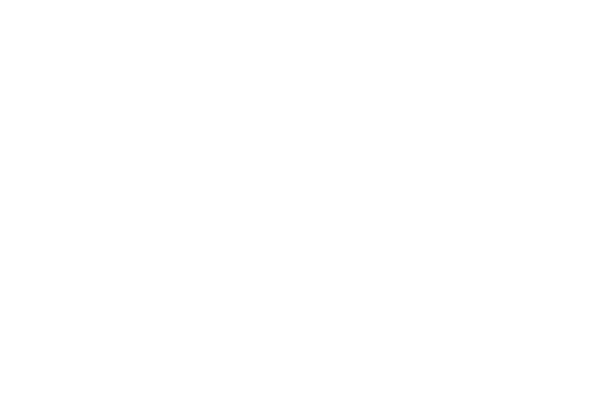

In [12]:
%matplotlib notebook
obs = controller.get_obs()
rgb = obs['color_sensor']
img, pred_classes, scores, pred_out, masks, boxes = runner.detector.predicted_img(rgb, show=True)
plt.imshow(img)#[50:100,100:150])

plt.show()

<IPython.core.display.Javascript object>


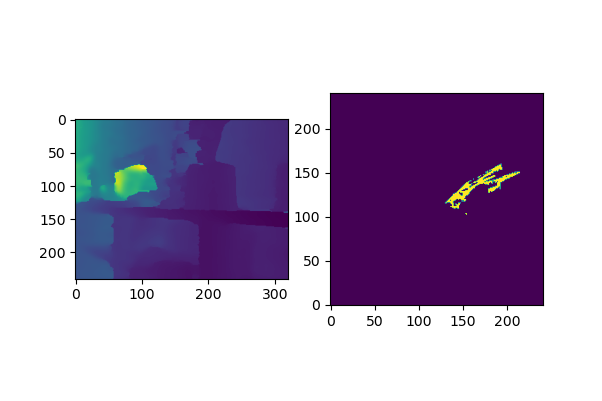

In [13]:
%matplotlib notebook
obs = controller.get_obs()
depth = obs['depth_sensor']
runner.local_agent.reset_with_curr_pose(runner.cur_position, runner.cur_rotation)
x_gt, y_gt, o_gt = runner.local_agent.get_mapper_pose_from_sim_pose(
            runner.local_agent.gt_new_sim_origin,
            runner.local_agent.sim_origin,
        )
runner.local_agent.update_visited_map([runner.local_agent.x_gt, runner.local_agent.y_gt], [x_gt, y_gt], gt=True)

runner.local_agent.x_gt, runner.local_agent.y_gt, runner.local_agent.o_gt = x_gt, y_gt, o_gt
x, y, o = runner.local_agent.x_gt, runner.local_agent.y_gt, runner.local_agent.o_gt

depth_cm = depth * 100.
gt_local_map, gt_local_exp_map, _ = runner.local_agent.mapper.update_map(
    depth_cm, (x, y, o),
    # curr_depth_img, (x, y, o)
    gt=True
)

plt.subplot(121)
plt.imshow(depth)
plt.subplot(122)
plt.imshow(gt_local_map, origin='lower')
plt.show()

In [14]:

success = 1

In [15]:
## --- evaluation --- ##
result = {
    'goal object': runner.goal_info['category'],
    'success': success,
    'action step': runner.action_step,
    'path_length': runner.path_length,
}


## --- save results --- ##
save_dir = f'epi_{runner.epi_num:02d}'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

runner.save_rgbd_video(runner.rgb_list, runner.depth_list, save_dir)

with open(f'{save_dir}/graph.pkl', 'wb') as f:
    pickle.dump(runner.graph_map, f)

cur_goal_obj_category_name = runner.goal_info['category']
if runner.vis_floorplan:
    runner.save_video(runner.vis_traj, save_dir)
    vis_save_dir = save_dir + '/result.png'
    runner.save_viewpoint_on_topdown_map(save_dir=vis_save_dir,
                                         vis_map=runner.base_map,
                                       bias_position=runner.abs_init_position,
                                       curr_position=runner.cur_position,
                                      curr_goal_position=runner.object_goal_position,
                                       result=result)


with open(
        f'{save_dir}/result.json', 'w') as f:
    json.dump(result, f)

print(result)


{'goal object': 'plant', 'success': 1, 'action step': 71, 'path_length': 10.260117543180462}


In [16]:
runner.path_length

10.260117543180462